

---


**Final Report**



> ## **Sistem Deteksi Tumor Otak Menggunakan YOLOv8: Sebuah Kajian Teknologi Medis**




---


**Dataset** : [Brain Tumor Object Detection Datasets](https://www.kaggle.com/datasets/davidbroberts/brain-tumor-object-detection-datasets/code)


---


**Method** : YOLOv8


---




> **Raden Fasya Mazaya Putri**

> **Zahwa Dewi Artika**

# **Library**

Install library

In [ ]:
!pip install ultralytics
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.2/663.2 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.1/254.1 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.2 MB/s eta 0:00:00


Import Library

In [ ]:
import ultralytics
from ultralytics import YOLO

import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import random
import wandb
import shutil

# **Dataset**

**Memanggil dataset dari Kaggle**

In [ ]:
!pip install -q opendatasets

import opendatasets as od
import pandas as pd

od.download('https://www.kaggle.com/datasets/davidbroberts/brain-tumor-object-detection-datasets')

## Update 28/12/2023 = {"username":"fasyam","key":"42100025ea96f0fcafb0e4ff81ecc334"}

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: fasyam
Your Kaggle Key: ··········


100%|██████████| 12.3M/12.3M [00:00<00:00, 14.3MB/s]


## **Axial Dataset**

### Pre-processing

**Inisiasi axial_t1wce_2_class menjadi axial_dataset**

In [ ]:
if os.path.exists('axial_dataset'):
    shutil.rmtree('axial_dataset')
shutil.copytree('/content/brain-tumor-object-detection-datasets/axial_t1wce_2_class/', 'axial_dataset')

'axial_dataset'

**Memanggil satu image dari folder train secara random**

In [ ]:
files = os.listdir('axial_dataset/images/train')
random_file = random.choice(files)
random_file = os.path.splitext(random_file)[0]
print(random_file)

00296_132


**Menampilkan random image tersebut**

(256, 192, 3)


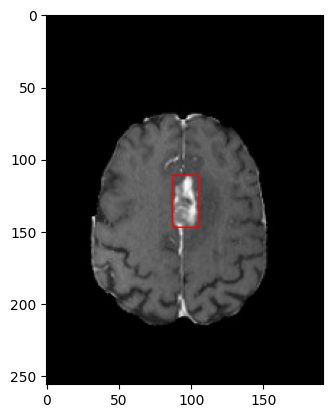

In [ ]:
with open(os.path.join('axial_dataset/labels/train', f'{random_file}.txt'),'r') as f:
    labels = f.readlines()
    labels = labels[0].split(' ')
    f.close()

img = cv2.imread(os.path.join('axial_dataset/images/train', f'{random_file}.jpg'), 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

tumor_class, x, y, w, h = int(labels[0]), float(labels[1]), float(labels[2]), float(labels[3]), float(labels[4])
x_pt1 = int((x - w/2) * img.shape[1])
y_pt1 = int((y - h/2) * img.shape[0])
x_pt2 = int((x + w/2) * img.shape[1])
y_pt2 = int((y + h/2) * img.shape[0])

if tumor_class == 1:
    colour = (255, 0, 0)
else:
    colour = (0, 255, 0)
cv2.rectangle(img, (x_pt1, y_pt1), (x_pt2, y_pt2), colour, 1)

print(img.shape)
plt.imshow(img)

**inisiasi directory images dan labels dari folder train dan test**

**Menampilkan jumlah isi dari masing-masing folder**

In [ ]:
axial_train_images = os.listdir('axial_dataset/images/train')
axial_test_images = os.listdir('axial_dataset/images/test')
axial_train_labels = os.listdir('axial_dataset/labels/train')
axial_test_labels = os.listdir('axial_dataset/labels/test')

axial_num_train_images = len(axial_train_images)
axial_num_test_images = len(axial_test_images)
axial_num_train_labels = len(axial_train_labels)
axial_num_test_labels = len(axial_test_labels)

print(axial_num_train_images, axial_num_test_images)
print(axial_num_train_labels, axial_num_test_labels)

310 75
296 75


**Terdapat ketidakseimbangan antara jumlah image dan jumlah label pada folder train,**

**oleh karena itu dilakukan penghapusan image yang tidak berlabel.**

In [ ]:
os.path.splitext(random_file)[0]
unlabelled = set(axial_train_images) - set([os.path.splitext(file)[0] + '.jpg' for file in axial_train_labels])

for image in unlabelled:
    os.remove(os.path.join('axial_dataset/images/train', image))

**Menampilkan jumlah isi dari masing-masing folder pasca penghapusan**

In [ ]:
axial_train_images = os.listdir('axial_dataset/images/train')
axial_test_images = os.listdir('axial_dataset/images/test')
axial_train_labels = os.listdir('axial_dataset/labels/train')
axial_test_labels = os.listdir('axial_dataset/labels/test')

axial_num_train_images = len(axial_train_images)
axial_num_test_images = len(axial_test_images)
axial_num_train_labels = len(axial_train_labels)
axial_num_test_labels = len(axial_test_labels)

print(axial_num_train_images, axial_num_test_images)
print(axial_num_train_labels, axial_num_test_labels)

296 75
296 75


**Melakukan splitting data validation sebesar 20% dari data train**

In [ ]:
val_split = int(axial_num_train_images * 0.2)
val_images = random.sample(axial_train_images, val_split)

if os.path.exists('axial_dataset/images/val'):
    shutil.rmtree('axial_dataset/images/val')
if os.path.exists('axial_dataset/labels/val'):
    shutil.rmtree('axial_dataset/labels/val')

os.mkdir('./axial_dataset/images/val')
os.mkdir('./axial_dataset/labels/val')

for image in val_images:
    shutil.move(os.path.join('axial_dataset/images/train', image), 'axial_dataset/images/val')

for image in val_images:
    label = os.path.splitext(image)[0] + '.txt'
    shutil.move(os.path.join('axial_dataset/labels/train', label), 'axial_dataset/labels/val')

**Membuat data yaml berisi dictionary label**

In [ ]:
text = """
path: /content/axial_dataset/
train: images/train
val: images/val

# Classes
nc: 2
names: ['negative','positive']
"""
with open("./axial_fixed_path.yaml", 'w') as file:
    file.write(text)

### Model Training

**Inisiasi model yang digunakan yaitu YOLO8 pre-trained models**

In [ ]:
model = YOLO('yolov8s.pt')

100%|██████████| 21.5M/21.5M [00:00<00:00, 120MB/s] 


**Melakukan training model**

In [ ]:
wandb.init(mode="disabled")

In [ ]:
axial_results = model.train(data='/content/axial_fixed_path.yaml', epochs=200, device=0)

Ultralytics YOLOv8.0.231 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/axial_fixed_path.yaml, epochs=200, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_

100%|██████████| 755k/755k [00:00<00:00, 40.7MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     29056  ultralytics.nn.modules.block.C2f             [64, 64, 1, True]             
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  2    788480  ultralytics.nn.modules.block.C2f             [256, 256, 2, True]           
  7                  -1  1   1180672  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 184MB/s]


AMP: checks passed ✅


train: Scanning /content/axial_dataset/labels/train... 237 images, 0 backgrounds, 0 corrupt: 100%|██████████| 237/237 [00:00<00:00, 2171.39it/s]

train: New cache created: /content/axial_dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/axial_dataset/labels/val... 59 images, 0 backgrounds, 0 corrupt: 100%|██████████| 59/59 [00:00<00:00, 1590.16it/s]

val: New cache created: /content/axial_dataset/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      4.08G      1.789      5.343      1.537         17        640: 100%|██████████| 15/15 [00:07<00:00,  2.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.26s/it]

                   all         59         64      0.357      0.409      0.347      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      4.16G      1.288      2.533      1.169         26        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]

                   all         59         64      0.374       0.72      0.414      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      4.17G      1.147      1.744      1.135         17        640: 100%|██████████| 15/15 [00:04<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.32it/s]

                   all         59         64      0.517      0.549      0.534      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      4.18G      1.175        1.7      1.187         28        640: 100%|██████████| 15/15 [00:04<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.69it/s]

                   all         59         64      0.506      0.609      0.528      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      4.17G      1.171      1.528      1.185         17        640: 100%|██████████| 15/15 [00:04<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.60it/s]

                   all         59         64      0.452      0.273      0.157     0.0603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      4.17G      1.235      1.575      1.166         27        640: 100%|██████████| 15/15 [00:04<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]

                   all         59         64      0.427      0.471      0.209       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      4.18G      1.233       1.38      1.179         17        640: 100%|██████████| 15/15 [00:03<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]

                   all         59         64      0.413      0.196      0.185      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      4.18G      1.146       1.36      1.113         12        640: 100%|██████████| 15/15 [00:04<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]

                   all         59         64      0.553      0.358      0.372      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      4.18G      1.172      1.287      1.138         29        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]

                   all         59         64      0.693      0.459      0.444      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      4.19G      1.204      1.272      1.177         18        640: 100%|██████████| 15/15 [00:04<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.36it/s]

                   all         59         64      0.478      0.502      0.416      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      4.18G      1.129      1.112      1.095         26        640: 100%|██████████| 15/15 [00:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         59         64      0.119      0.268     0.0438     0.0302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      4.18G      1.166      1.176      1.096         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]

                   all         59         64     0.0908     0.0526     0.0447     0.0295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      4.17G      1.072      1.187        1.1         27        640: 100%|██████████| 15/15 [00:04<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all         59         64      0.508      0.525      0.504       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      4.19G      1.102      1.113      1.112         20        640: 100%|██████████| 15/15 [00:04<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.51it/s]

                   all         59         64      0.653      0.646      0.664      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      4.18G      1.092     0.9878      1.099         20        640: 100%|██████████| 15/15 [00:04<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         59         64        0.6      0.594      0.669      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      4.18G      1.022      1.033      1.091         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.40it/s]

                   all         59         64      0.745      0.466      0.655      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      4.18G      1.067      1.055      1.096         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]

                   all         59         64      0.491      0.687      0.616      0.414



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      4.35G      1.095      1.098      1.106         26        640: 100%|██████████| 15/15 [00:05<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]

                   all         59         64      0.647      0.648      0.672      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      4.18G      1.128      1.041      1.098         26        640: 100%|██████████| 15/15 [00:04<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.44it/s]

                   all         59         64       0.54       0.55      0.369      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200       4.2G      1.038      1.009      1.078         17        640: 100%|██████████| 15/15 [00:04<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]

                   all         59         64      0.736      0.704      0.712      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      4.33G      1.031     0.9863      1.069         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]

                   all         59         64      0.654      0.603      0.698      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      4.19G      1.066     0.9768      1.111         16        640: 100%|██████████| 15/15 [00:04<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]

                   all         59         64      0.592      0.723      0.679      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      4.17G      1.045      1.006      1.078         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.28it/s]

                   all         59         64      0.612      0.572      0.645      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      4.34G      1.058     0.9281      1.094         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]

                   all         59         64      0.854      0.752      0.817      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      4.17G      1.065     0.8962      1.073         28        640: 100%|██████████| 15/15 [00:05<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.45it/s]

                   all         59         64      0.821      0.681      0.857      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      4.34G      1.086     0.9236      1.082         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]

                   all         59         64      0.772      0.786      0.875      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      4.18G          1     0.9095      1.058         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]

                   all         59         64       0.73      0.707      0.787      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      4.34G     0.9754     0.9062      1.033         20        640: 100%|██████████| 15/15 [00:04<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]

                   all         59         64      0.837      0.802      0.856      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      4.34G     0.9671      0.829      1.038         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         59         64      0.593      0.891      0.871      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      4.19G      1.012     0.8302      1.038         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]

                   all         59         64      0.572      0.725      0.756      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      4.18G     0.9948     0.8317      1.044         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]

                   all         59         64      0.619      0.828      0.785      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      4.34G      1.065     0.8198       1.09         23        640: 100%|██████████| 15/15 [00:05<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.62it/s]

                   all         59         64      0.783      0.812      0.874      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      4.17G      0.964     0.8165      1.057         17        640: 100%|██████████| 15/15 [00:04<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.27it/s]

                   all         59         64      0.848      0.747      0.859      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      4.19G      1.035     0.8764      1.058         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]

                   all         59         64       0.56      0.833      0.817      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      4.18G      0.957     0.8974      1.024         17        640: 100%|██████████| 15/15 [00:04<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.29it/s]

                   all         59         64      0.655      0.763      0.836      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      4.34G     0.9652     0.7811      1.031         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.59it/s]

                   all         59         64      0.677      0.773      0.828      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      4.18G     0.9242     0.7655      1.027         21        640: 100%|██████████| 15/15 [00:05<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]

                   all         59         64       0.58      0.786      0.774      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      4.21G     0.9852     0.9189      1.055         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.94it/s]

                   all         59         64      0.533      0.754      0.691      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200       4.2G          1     0.8115      1.058         29        640: 100%|██████████| 15/15 [00:04<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.45it/s]

                   all         59         64      0.734      0.817      0.835      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      4.18G     0.9016     0.7111      1.016         18        640: 100%|██████████| 15/15 [00:04<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.44it/s]

                   all         59         64      0.716      0.881      0.856      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      4.18G     0.9336     0.7015      1.028         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.89it/s]

                   all         59         64      0.783      0.874      0.907      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      4.19G     0.9269     0.7124     0.9969         27        640: 100%|██████████| 15/15 [00:04<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.97it/s]

                   all         59         64      0.784      0.887      0.906       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200       4.2G     0.9175     0.7709     0.9911         15        640: 100%|██████████| 15/15 [00:04<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]

                   all         59         64      0.716       0.82      0.791      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      4.18G     0.9191     0.7813      1.022         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]

                   all         59         64      0.812      0.825      0.879      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      4.17G     0.8922     0.7234     0.9964         16        640: 100%|██████████| 15/15 [00:04<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]

                   all         59         64      0.606      0.794      0.812      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      4.19G     0.8771     0.6791     0.9946         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]

                   all         59         64      0.522      0.812      0.718      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200       4.2G     0.9074     0.6805     0.9814         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]

                   all         59         64       0.56      0.818       0.74      0.507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      4.34G     0.8531     0.6743     0.9766         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.46it/s]

                   all         59         64      0.798      0.914      0.906       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      4.17G     0.8812     0.7213     0.9898         26        640: 100%|██████████| 15/15 [00:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.31it/s]

                   all         59         64      0.766      0.835      0.851      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      4.35G     0.8879     0.8352     0.9976         20        640: 100%|██████████| 15/15 [00:04<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.28it/s]

                   all         59         64      0.659      0.709      0.707      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      4.19G     0.9122     0.7521       1.01         20        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.75it/s]

                   all         59         64       0.68      0.699      0.784      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      4.18G     0.9345     0.8143      1.041         26        640: 100%|██████████| 15/15 [00:04<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]

                   all         59         64       0.78      0.789      0.857      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      4.17G     0.8549     0.6952     0.9739         28        640: 100%|██████████| 15/15 [00:03<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.29it/s]

                   all         59         64      0.751      0.743      0.802      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200       4.2G     0.9125     0.7102      1.023         24        640: 100%|██████████| 15/15 [00:05<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.50it/s]

                   all         59         64      0.791      0.794      0.881      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      4.17G     0.8767     0.6619      0.995         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.58it/s]

                   all         59         64        0.7      0.857      0.877      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      4.18G     0.8719      0.652     0.9804         20        640: 100%|██████████| 15/15 [00:04<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]

                   all         59         64      0.916      0.668      0.843      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      4.17G     0.8207     0.6246     0.9629         15        640: 100%|██████████| 15/15 [00:03<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]

                   all         59         64      0.805       0.75      0.856      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      4.18G     0.8654     0.6818      0.976         28        640: 100%|██████████| 15/15 [00:04<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]

                   all         59         64      0.774      0.898       0.92      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      4.17G      0.861     0.6213      0.978         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]

                   all         59         64        0.8      0.852      0.902      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      4.34G     0.8405     0.6071     0.9725         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.54it/s]

                   all         59         64      0.728      0.629      0.792      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      4.17G     0.8518       0.61     0.9862         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  2.00it/s]

                   all         59         64      0.731      0.818      0.873      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      4.18G     0.8405     0.6183     0.9717         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.47it/s]

                   all         59         64      0.833      0.726      0.863      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      4.18G     0.8475     0.6044     0.9771         27        640: 100%|██████████| 15/15 [00:04<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]

                   all         59         64      0.772      0.814      0.866       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      4.34G     0.8173     0.5887     0.9462         16        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]

                   all         59         64      0.828      0.757      0.855      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      4.34G     0.8308     0.5918     0.9919         21        640: 100%|██████████| 15/15 [00:03<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]

                   all         59         64      0.856      0.779      0.911      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      4.35G     0.8529     0.6382      1.001         23        640: 100%|██████████| 15/15 [00:05<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]

                   all         59         64      0.895      0.828      0.939      0.676



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      4.34G     0.8017     0.5979     0.9719         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]

                   all         59         64      0.896      0.874       0.91      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      4.34G     0.8201     0.5501     0.9663         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]

                   all         59         64      0.814      0.768      0.866      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      4.17G     0.8455     0.6015     0.9756         18        640: 100%|██████████| 15/15 [00:04<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.37it/s]

                   all         59         64      0.914      0.731       0.87      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      4.35G     0.8403     0.6103     0.9771         18        640: 100%|██████████| 15/15 [00:04<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.55it/s]

                   all         59         64      0.777      0.817      0.875      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      4.34G     0.8165     0.6231     0.9714         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.50it/s]

                   all         59         64       0.84      0.765      0.863      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      4.34G     0.8472     0.5871     0.9825         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]

                   all         59         64      0.825      0.801      0.912      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      4.17G     0.8079     0.5692     0.9696         18        640: 100%|██████████| 15/15 [00:04<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         59         64      0.864      0.847       0.94      0.673



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200       4.2G      0.759     0.5479     0.9422         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.43it/s]

                   all         59         64      0.752      0.899      0.887      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      4.18G     0.8171     0.5771       0.99         17        640: 100%|██████████| 15/15 [00:04<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.70it/s]

                   all         59         64      0.723       0.85      0.872      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200       4.2G     0.7947     0.5289     0.9798         20        640: 100%|██████████| 15/15 [00:04<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]

                   all         59         64      0.807      0.881      0.908      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      4.17G     0.7848      0.581     0.9585         28        640: 100%|██████████| 15/15 [00:03<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.32it/s]

                   all         59         64      0.899      0.826      0.919      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      4.19G     0.8167     0.5689     0.9796         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         59         64       0.93      0.784      0.887      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      4.19G       0.78     0.5638     0.9555         29        640: 100%|██████████| 15/15 [00:04<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]

                   all         59         64      0.762      0.771      0.823      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      4.18G      0.817      0.561     0.9897         26        640: 100%|██████████| 15/15 [00:04<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.41it/s]

                   all         59         64      0.745      0.835      0.891      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      4.17G     0.7333     0.5248     0.9619         26        640: 100%|██████████| 15/15 [00:04<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]

                   all         59         64      0.798      0.904       0.91      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200       4.2G     0.7504     0.5033     0.9534         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]

                   all         59         64      0.898      0.801      0.875      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      4.17G     0.7356     0.5266      0.953         24        640: 100%|██████████| 15/15 [00:05<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.72it/s]

                   all         59         64      0.635      0.814      0.801      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      4.18G      0.716     0.4995     0.9196         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.28it/s]

                   all         59         64      0.821      0.821      0.905      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      4.17G     0.7632     0.5166      0.935         18        640: 100%|██████████| 15/15 [00:04<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]

                   all         59         64      0.919      0.779      0.884      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      4.19G     0.7349     0.4969     0.9388         15        640: 100%|██████████| 15/15 [00:04<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]

                   all         59         64      0.888      0.851      0.883      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      4.19G     0.7665     0.5386     0.9671         14        640: 100%|██████████| 15/15 [00:04<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.73it/s]

                   all         59         64       0.87      0.816      0.916      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      4.18G     0.7419     0.5459     0.9481         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]

                   all         59         64      0.934       0.87      0.942      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      4.33G     0.7528     0.5568     0.9465         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]

                   all         59         64      0.942      0.891      0.942      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      4.36G     0.6896     0.5141     0.9158         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]

                   all         59         64      0.814       0.82      0.862      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      4.17G     0.7461     0.5133     0.9526         16        640: 100%|██████████| 15/15 [00:04<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.41it/s]

                   all         59         64      0.872      0.865      0.931      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      4.34G      0.751     0.5163     0.9678         26        640: 100%|██████████| 15/15 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]

                   all         59         64      0.834      0.847       0.91       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      4.17G      0.677     0.5269     0.9067         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.15it/s]

                   all         59         64      0.704      0.768      0.763      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      4.18G     0.7823     0.5377     0.9439         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]

                   all         59         64      0.872      0.843      0.931      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      4.17G     0.7254     0.5615     0.9539         20        640: 100%|██████████| 15/15 [00:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.56it/s]

                   all         59         64      0.881       0.88      0.921      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      4.18G     0.7052     0.5024      0.918         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.57it/s]

                   all         59         64      0.974      0.817      0.954      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      4.17G     0.6746      0.475     0.9354         29        640: 100%|██████████| 15/15 [00:04<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         59         64      0.888      0.917      0.964      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      4.18G     0.7128     0.4967     0.9202         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.44it/s]

                   all         59         64      0.864      0.892      0.941      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      4.18G     0.7139       0.47     0.9274         20        640: 100%|██████████| 15/15 [00:04<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]

                   all         59         64      0.958       0.85      0.947      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      4.34G     0.7016     0.4551     0.9292         17        640: 100%|██████████| 15/15 [00:04<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.56it/s]

                   all         59         64      0.937      0.816       0.89      0.655



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      4.18G     0.7104     0.4722     0.9137         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]

                   all         59         64      0.943      0.836      0.912      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      4.19G     0.6821     0.4477     0.9397         17        640: 100%|██████████| 15/15 [00:04<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]

                   all         59         64      0.854      0.885      0.922      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      4.18G     0.6956     0.4402     0.9379         26        640: 100%|██████████| 15/15 [00:04<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]

                   all         59         64      0.894      0.806      0.886      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      4.34G     0.6839     0.4344     0.9149         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  2.00it/s]

                   all         59         64      0.911      0.778      0.867      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      4.17G     0.6602     0.4387     0.9124         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.76it/s]

                   all         59         64      0.938      0.777      0.882      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      4.19G     0.6417     0.4145     0.8934         17        640: 100%|██████████| 15/15 [00:04<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]

                   all         59         64      0.816      0.867      0.922      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      4.18G     0.7088     0.4831      0.954         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         59         64      0.845      0.768      0.886       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      4.18G     0.6847     0.4619     0.9181         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]

                   all         59         64      0.833      0.904      0.937      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      4.17G     0.6343     0.4486     0.9035         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         59         64      0.913      0.858      0.943      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200       4.2G       0.67     0.4344     0.9241         32        640: 100%|██████████| 15/15 [00:04<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.75it/s]

                   all         59         64      0.907      0.831      0.913      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      4.18G      0.669     0.4274     0.9376         28        640: 100%|██████████| 15/15 [00:04<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.38it/s]

                   all         59         64      0.819      0.929      0.935      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      4.17G      0.656     0.4673     0.9077         25        640: 100%|██████████| 15/15 [00:05<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.53it/s]

                   all         59         64      0.875      0.896      0.953      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      4.17G     0.6438     0.4165     0.8932         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]

                   all         59         64      0.874      0.908       0.96      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200       4.2G     0.6528     0.4304     0.9154         20        640: 100%|██████████| 15/15 [00:04<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]

                   all         59         64       0.84        0.8      0.899      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      4.18G     0.6909     0.4328     0.9324         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]

                   all         59         64      0.821      0.916      0.933      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      4.18G     0.6324     0.4222     0.9023         18        640: 100%|██████████| 15/15 [00:04<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.29it/s]

                   all         59         64      0.893      0.935      0.969      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      4.33G     0.6425     0.4154     0.9049         18        640: 100%|██████████| 15/15 [00:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.45it/s]

                   all         59         64      0.909      0.724       0.88      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      4.19G     0.6257     0.4046     0.8998         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.14it/s]

                   all         59         64      0.803      0.724      0.859      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      4.18G     0.6275     0.4237     0.9183         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.35it/s]

                   all         59         64      0.827       0.81      0.903      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      4.17G     0.6695     0.4415     0.9243         30        640: 100%|██████████| 15/15 [00:04<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]

                   all         59         64      0.942      0.864       0.95      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      4.18G     0.6377     0.4104     0.9269         17        640: 100%|██████████| 15/15 [00:04<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]

                   all         59         64      0.969      0.813      0.928      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      4.19G     0.6188     0.4225     0.9055         28        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.15it/s]

                   all         59         64      0.966      0.793      0.914      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      4.18G     0.6356     0.3951     0.9298         20        640: 100%|██████████| 15/15 [00:04<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]

                   all         59         64      0.855      0.775      0.901      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      4.18G     0.6041     0.4137     0.8998         29        640: 100%|██████████| 15/15 [00:05<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.56it/s]

                   all         59         64      0.936      0.793      0.922      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      4.33G     0.6579     0.4327     0.9327         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.94it/s]

                   all         59         64      0.875      0.925      0.946      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      4.19G     0.6722     0.4283     0.9215         18        640: 100%|██████████| 15/15 [00:04<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all         59         64      0.911      0.885      0.951      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      4.18G     0.6663     0.4122     0.9202         27        640: 100%|██████████| 15/15 [00:04<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]

                   all         59         64      0.942      0.888      0.972      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      4.34G     0.5691      0.377     0.8761         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

                   all         59         64      0.941      0.896      0.971      0.715



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      4.17G     0.5888     0.3904     0.8855         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.90it/s]

                   all         59         64       0.86      0.914      0.948      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      4.34G     0.5981     0.3984        0.9         16        640: 100%|██████████| 15/15 [00:04<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]

                   all         59         64      0.795       0.87       0.92      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      4.34G     0.5962     0.4052     0.8986         27        640: 100%|██████████| 15/15 [00:05<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.37it/s]

                   all         59         64       0.85      0.873       0.94      0.689



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      4.34G     0.5414     0.3531     0.8774         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.49it/s]

                   all         59         64      0.908      0.866      0.928      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      4.18G     0.6053     0.3827     0.9068         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         59         64      0.907      0.872      0.896      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      4.21G     0.5734     0.3999     0.8837         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]

                   all         59         64      0.874      0.856      0.896      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      4.19G     0.6155     0.3933     0.9093         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.42it/s]

                   all         59         64      0.956      0.838      0.945      0.707



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      4.36G     0.5721       0.37     0.9039         26        640: 100%|██████████| 15/15 [00:05<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.62it/s]

                   all         59         64      0.934      0.843      0.945      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      4.17G     0.5908      0.369      0.876         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.32it/s]

                   all         59         64      0.781      0.903      0.915      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      4.21G     0.5663     0.3602     0.8926         20        640: 100%|██████████| 15/15 [00:04<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]

                   all         59         64      0.907       0.78      0.893      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      4.17G     0.5718     0.3811     0.8883         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]

                   all         59         64      0.933      0.768       0.89      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      4.19G     0.5937     0.3724     0.8965         26        640: 100%|██████████| 15/15 [00:04<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]

                   all         59         64      0.927      0.854      0.947      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      4.33G     0.5223     0.3553      0.875         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.48it/s]

                   all         59         64      0.919      0.918      0.968      0.714



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      4.19G     0.5492     0.3824     0.8972         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.29it/s]

                   all         59         64      0.835      0.911      0.948      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200       4.2G      0.555     0.3722     0.8906         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]

                   all         59         64      0.874      0.906      0.949       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      4.18G      0.552     0.3644     0.8774         17        640: 100%|██████████| 15/15 [00:04<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.39it/s]

                   all         59         64      0.845      0.891      0.937      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      4.17G     0.5553     0.3679     0.9029         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.40it/s]

                   all         59         64      0.941      0.817      0.939      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200       4.2G     0.5385     0.3756     0.8926         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.73it/s]

                   all         59         64      0.936      0.835       0.95      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      4.18G     0.5638     0.3692     0.8891         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.44it/s]

                   all         59         64      0.897      0.929      0.953      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200       4.2G     0.5578      0.349     0.8904         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]

                   all         59         64      0.996      0.843      0.961      0.698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      4.17G     0.5504     0.3648     0.8879         28        640: 100%|██████████| 15/15 [00:04<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.47it/s]

                   all         59         64      0.911      0.892      0.958      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      4.19G     0.5422     0.3599     0.9045         17        640: 100%|██████████| 15/15 [00:04<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]

                   all         59         64       0.83      0.935      0.941      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200       4.2G     0.5667     0.3564     0.8893         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.30it/s]

                   all         59         64      0.845       0.94      0.942        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200       4.2G     0.5472     0.3643     0.8871         16        640: 100%|██████████| 15/15 [00:04<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.38it/s]

                   all         59         64      0.849      0.901      0.939      0.709



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      4.17G     0.5181     0.3388     0.8704         26        640: 100%|██████████| 15/15 [00:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.18it/s]

                   all         59         64      0.912      0.791      0.927      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      4.18G     0.5113     0.3837     0.8665         20        640: 100%|██████████| 15/15 [00:04<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.01it/s]

                   all         59         64      0.889      0.795      0.924      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      4.18G     0.5243     0.3837     0.8971         25        640: 100%|██████████| 15/15 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]

                   all         59         64      0.904       0.78      0.917      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      4.19G      0.521     0.3606     0.8869         14        640: 100%|██████████| 15/15 [00:04<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]

                   all         59         64      0.883      0.868       0.93      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      4.17G     0.5001     0.3701     0.8688         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]

                   all         59         64      0.959      0.833      0.944      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      4.19G     0.5099      0.385     0.8676         18        640: 100%|██████████| 15/15 [00:05<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         59         64      0.872      0.883      0.928      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      4.18G     0.5327     0.3646     0.8741         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]

                   all         59         64      0.843      0.876       0.92      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      4.34G      0.531     0.3789      0.872         26        640: 100%|██████████| 15/15 [00:04<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all         59         64      0.901      0.814      0.924      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      4.17G     0.4881     0.3495     0.8653         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.27it/s]

                   all         59         64      0.828      0.897      0.938       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200       4.2G     0.5018     0.3228      0.858         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]

                   all         59         64      0.865      0.919      0.948      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      4.18G     0.4659     0.3251     0.8468         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.67it/s]

                   all         59         64       0.93      0.821       0.94      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      4.17G     0.4959     0.3368     0.8781         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]

                   all         59         64      0.788      0.908      0.929      0.695



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      4.33G     0.4988     0.3234     0.8635         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]

                   all         59         64      0.813       0.88      0.933      0.682



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200       4.2G     0.4823     0.3196     0.8646         20        640: 100%|██████████| 15/15 [00:04<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]

                   all         59         64       0.82      0.896      0.935      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200       4.2G     0.4988     0.3265     0.8757         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.40it/s]

                   all         59         64      0.947      0.784       0.92      0.671



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      4.33G     0.4797     0.3309     0.8647         15        640: 100%|██████████| 15/15 [00:04<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.89it/s]

                   all         59         64      0.952      0.811      0.922      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      4.17G     0.4505     0.2949     0.8559         22        640: 100%|██████████| 15/15 [00:04<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

                   all         59         64      0.975      0.817      0.934      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200       4.2G     0.4756     0.3219     0.8607         25        640: 100%|██████████| 15/15 [00:05<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]

                   all         59         64      0.859      0.918      0.952      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      4.18G     0.4933     0.3228     0.8633         14        640: 100%|██████████| 15/15 [00:04<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]

                   all         59         64      0.881      0.873      0.953      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      4.34G     0.4989     0.3239     0.8869         24        640: 100%|██████████| 15/15 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all         59         64      0.843      0.907      0.947       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      4.34G     0.4579     0.3083      0.869         21        640: 100%|██████████| 15/15 [00:04<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]

                   all         59         64      0.861       0.94      0.941      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      4.35G     0.4686     0.2985     0.8674         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]

                   all         59         64      0.896      0.919      0.942      0.692



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      4.18G     0.4656     0.3067     0.8525         21        640: 100%|██████████| 15/15 [00:05<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]

                   all         59         64      0.826       0.94      0.936      0.685



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      4.18G      0.455      0.301     0.8592         23        640: 100%|██████████| 15/15 [00:04<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]

                   all         59         64      0.863      0.929      0.944      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      4.17G     0.4569     0.3121       0.86         19        640: 100%|██████████| 15/15 [00:04<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]

                   all         59         64       0.89      0.929      0.943      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      4.35G     0.4625     0.3074     0.8707         26        640: 100%|██████████| 15/15 [00:04<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]

                   all         59         64      0.916      0.911      0.955        0.7
Stopping training early as no improvement observed in last 50 epochs. Best results observed at epoch 128, best model saved as best.pt.
To update EarlyStopping(patience=50) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



178 epochs completed in 0.295 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train/weights/best.pt, 22.5MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.0.231 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11126358 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]


                   all         59         64      0.941      0.896      0.971      0.716
              negative         59         19      0.882      0.947      0.957       0.72
              positive         59         45          1      0.845      0.985      0.712
Speed: 0.2ms preprocess, 3.9ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/train


**Menampilkan Board Training**

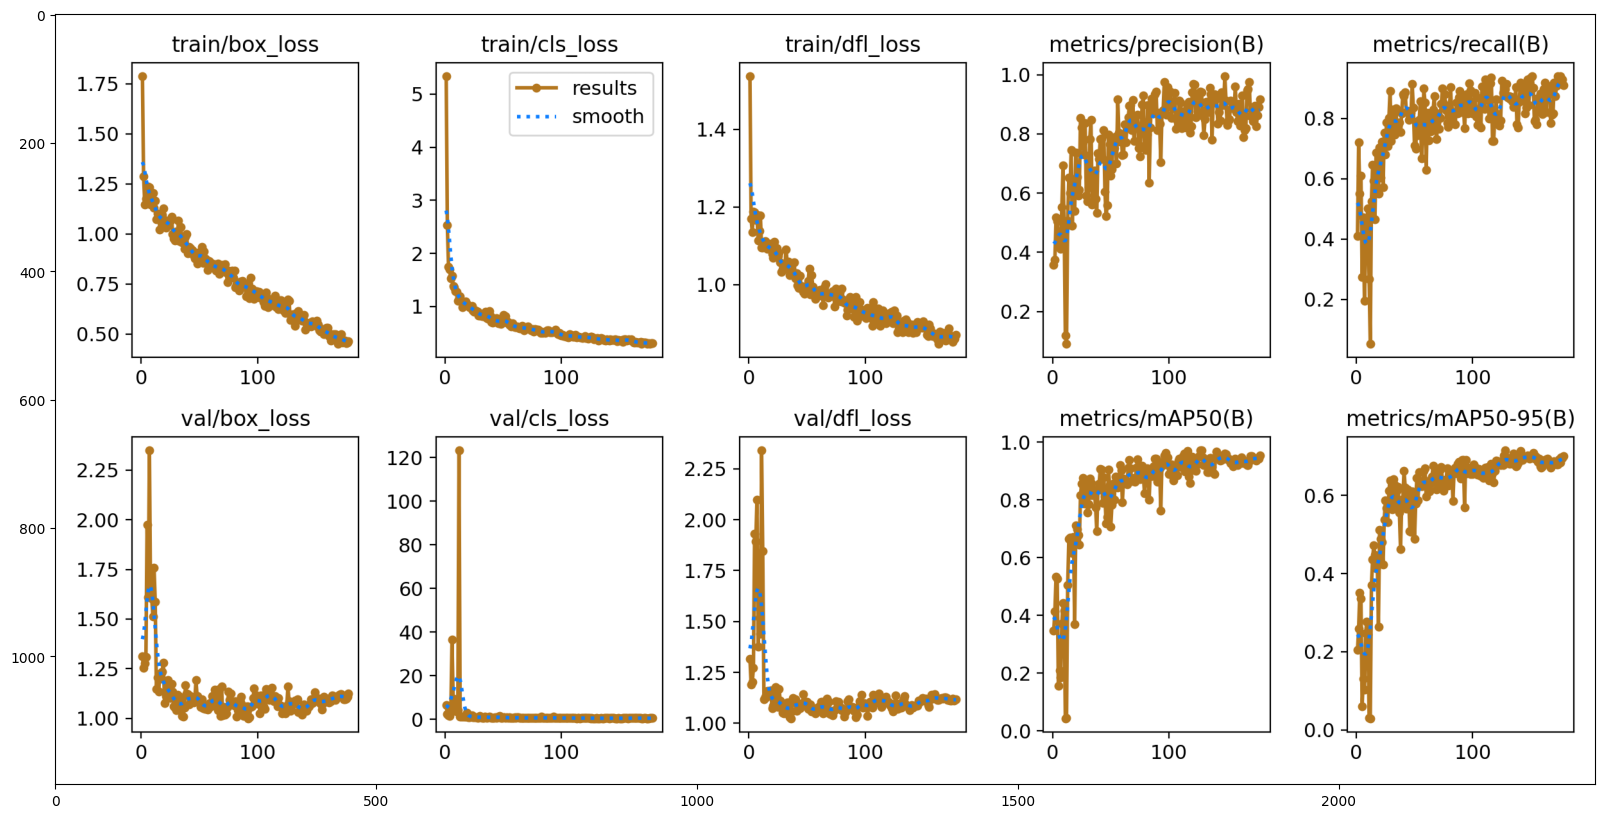

In [ ]:
axial_training_save_dir = '/content/' + str(axial_results.save_dir)

plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(axial_training_save_dir, 'results.png'))
plt.imshow(img)
plt.show()

**Menampilkan Confusion Matrix hasil training**

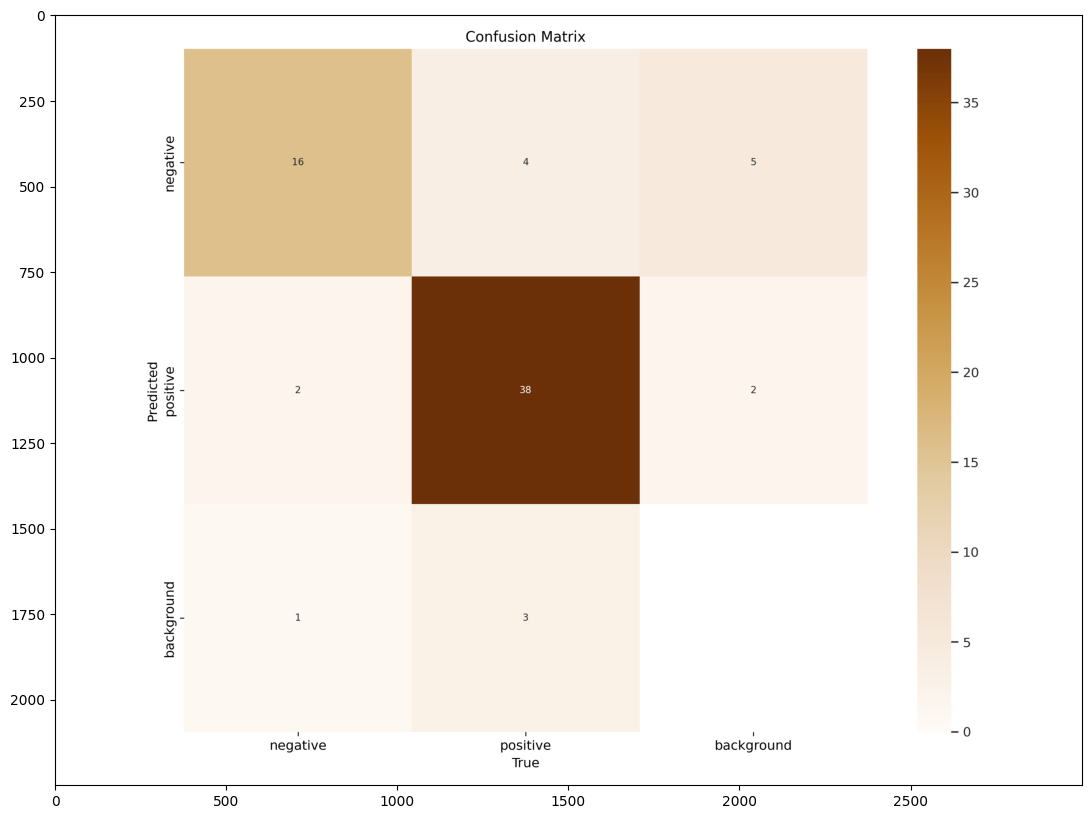

In [ ]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(axial_training_save_dir, 'confusion_matrix.png'))
plt.imshow(img)
plt.show()

**Menampilkan hasil training**

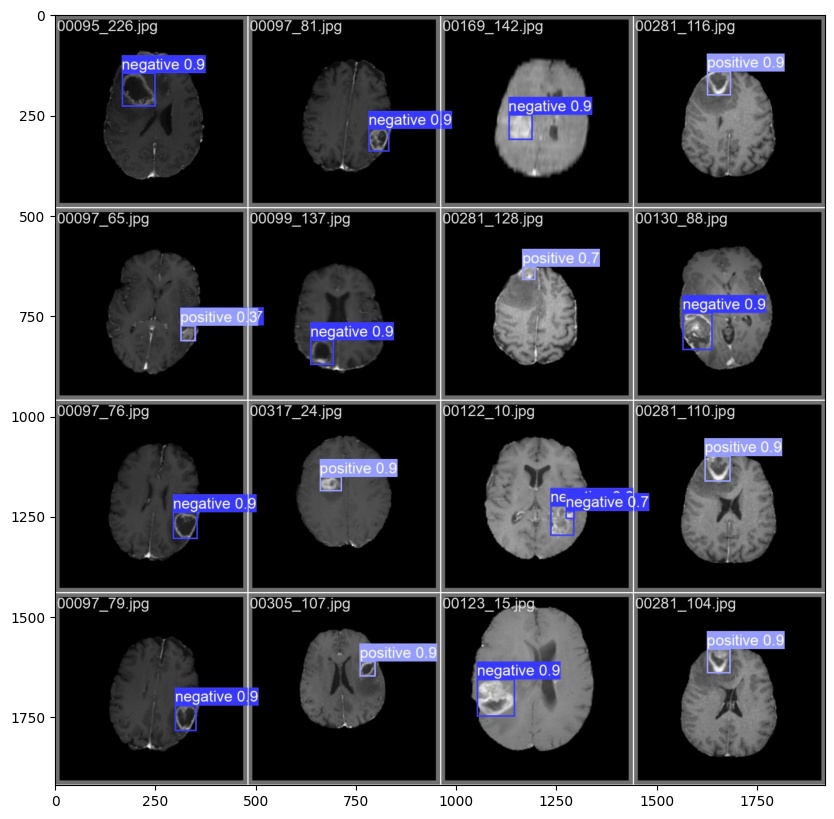

In [ ]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(axial_training_save_dir, 'val_batch0_pred.jpg'))
plt.imshow(img)
plt.show()

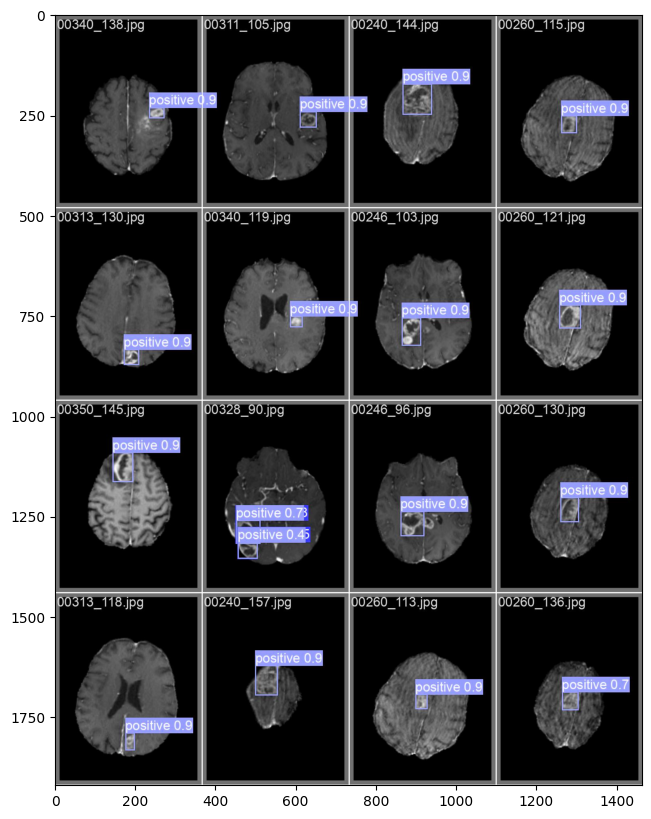

In [ ]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(axial_training_save_dir, 'val_batch1_pred.jpg'))
plt.imshow(img)
plt.show()

### Prediction / Testing

**Mengimplementasikan hasil training model ke test folder**

In [ ]:
axial_trained_model = YOLO(axial_training_save_dir + '/weights/best.pt')
axial_predictions = axial_trained_model.predict(
    source="/content/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test",
    conf=0.4, save_txt=True, save_conf=True)


image 1/75 /content/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test/00018_101.jpg: 640x640 1 negative, 16.2ms
image 2/75 /content/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test/00018_109.jpg: 640x640 1 negative, 16.0ms
image 3/75 /content/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test/00018_111.jpg: 640x640 1 negative, 16.0ms
image 4/75 /content/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test/00018_117.jpg: 640x640 1 negative, 16.0ms
image 5/75 /content/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test/00018_121.jpg: 640x640 1 negative, 16.0ms
image 6/75 /content/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test/00018_126.jpg: 640x640 1 negative, 15.9ms
image 7/75 /content/brain-tumor-object-detection-datasets/axial_t1wce_2_class/images/test/00018_134.jpg: 640x640 (no detections), 16.0ms
image 8/75 /content/brain-tumor-object-detection-datasets/axial_t1wce_

In [ ]:
axial_predictions_save_dir = '/content/' + axial_predictions[0].save_dir + '/labels'

In [ ]:
text = """
path: /content/axial_dataset/
train: images/train
val: images/test

# Classes
nc: 2
names: ['negative','positive']
"""
with open("./axial_test.yaml", 'w') as file:
    file.write(text)

In [ ]:
axial_metrics = axial_trained_model.val(data="axial_test.yaml")  # no arguments needed, dataset and settings remembered

Ultralytics YOLOv8.0.231 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/axial_dataset/labels/test... 75 images, 0 backgrounds, 0 corrupt: 100%|██████████| 75/75 [00:00<00:00, 683.02it/s]

val: New cache created: /content/axial_dataset/labels/test.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.59it/s]


                   all         75         81      0.903      0.807      0.902      0.644
              negative         75         81      0.903      0.807      0.902      0.644
Speed: 0.4ms preprocess, 16.3ms inference, 0.0ms loss, 6.8ms postprocess per image
Results saved to runs/detect/val


**Menampilkan Confusion Matrix hasil testing**

In [ ]:
axial_test_save_dir = '/content/' + str(axial_metrics.save_dir)

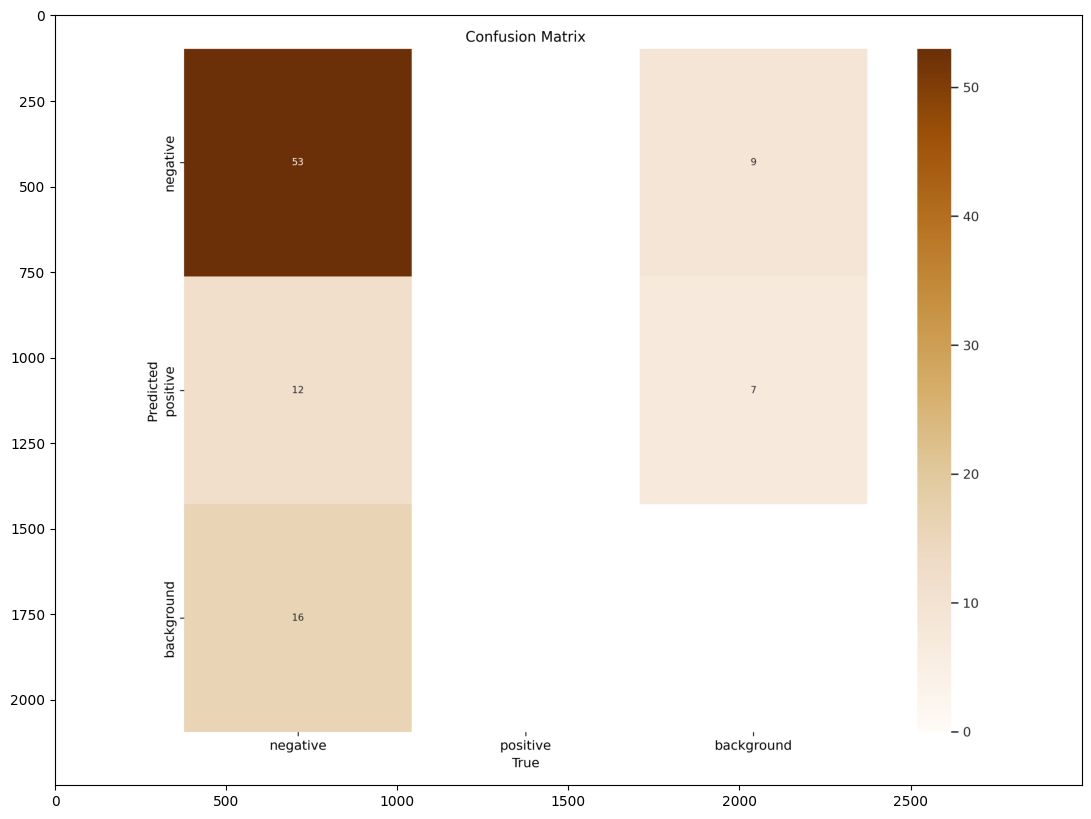

In [ ]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(axial_test_save_dir, 'confusion_matrix.png'))
plt.imshow(img)
plt.show()

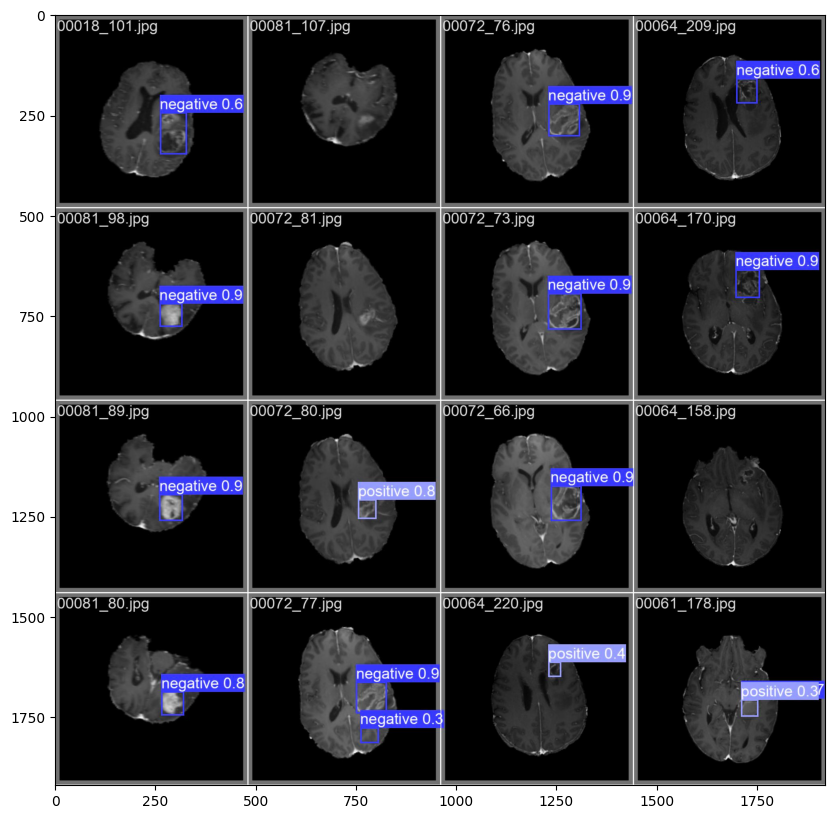

In [ ]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(axial_test_save_dir, 'val_batch0_pred.jpg'))
plt.imshow(img)
plt.show()

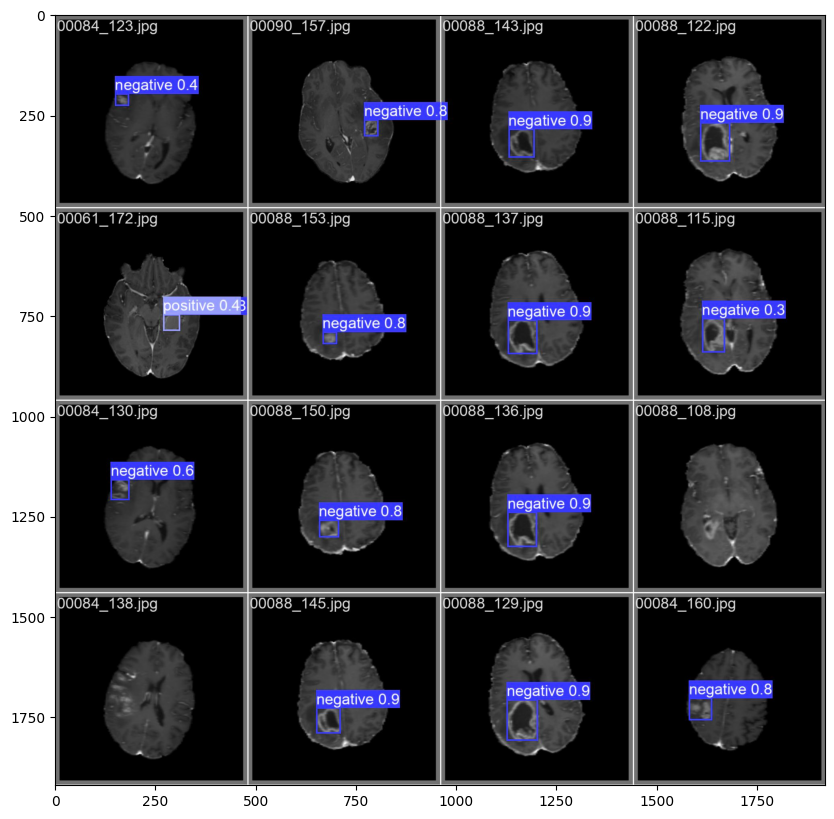

In [ ]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(axial_test_save_dir, 'val_batch1_pred.jpg'))
plt.imshow(img)
plt.show()

### Compare (repeatable)

['0', '0.61066', '0.60282', '0.0924395', '0.0915029', '0.827071\n']
['0', '0.612676', '0.603286', '0.100939', '0.089202']


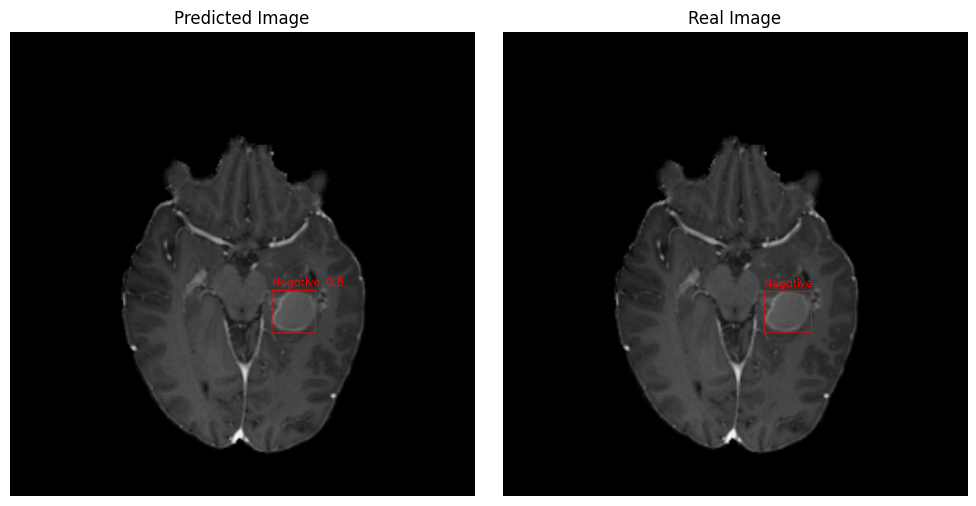

In [ ]:
def draw_bbox(file_path, filename, img):
    with open(os.path.join(file_path, f'{filename}.txt'),'r') as f:
        labels = f.readlines()
        labels = labels[0].split(' ')
        print(labels)
        f.close()

    tumor_class, x, y, w, h = int(labels[0]), float(labels[1]), float(labels[2]), float(labels[3]), float(labels[4])
    x_pt1 = int((x - w/2) * img.shape[1])
    y_pt1 = int((y - h/2) * img.shape[0])
    x_pt2 = int((x + w/2) * img.shape[1])
    y_pt2 = int((y + h/2) * img.shape[0])

    if tumor_class == 0:
        colour = (255, 0, 0)
        label = 'Negative'
    else:
        colour = (0, 255, 0)
        label = 'Positive'
    if len(labels) > 5:
        prob = float(labels[5])
        prob = round(prob, 1)
        prob = str(prob)
        label = label + ' ' + prob

    cv2.rectangle(img, (x_pt1, y_pt1), (x_pt2, y_pt2), colour, 1)
    cv2.putText(img, label, (x_pt1, y_pt1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, colour, 1)

files = os.listdir(axial_predictions_save_dir)
random_file = random.choice(files)
random_file = os.path.splitext(random_file)[0]

img_pred = cv2.imread(os.path.join('axial_dataset/images/test', f'{random_file}.jpg'), 1)
img_pred = cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)
draw_bbox(axial_predictions_save_dir, random_file, img_pred)

img_real = cv2.imread(os.path.join('axial_dataset/images/test', f'{random_file}.jpg'), 1)
img_real = cv2.cvtColor(img_real, cv2.COLOR_BGR2RGB)
draw_bbox('axial_dataset/labels/test', random_file, img_real)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img_pred)
axes[0].set_title('Predicted Image')
axes[0].axis('off')

axes[1].imshow(img_real)
axes[1].set_title('Real Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## **Coronal Dataset**

### Pre-processing

**Inisiasi coronal_t1wce_2_class menjadi coronal_dataset**

In [ ]:
if os.path.exists('coronal_dataset'):
    shutil.rmtree('coronal_dataset')
shutil.copytree('/content/brain-tumor-object-detection-datasets/coronal_t1wce_2_class/', 'coronal_dataset')

'coronal_dataset'

**Memanggil satu image dari folder train secara random**

In [ ]:
files = os.listdir('coronal_dataset/images/train')
random_file = random.choice(files)
random_file = os.path.splitext(random_file)[0]
print(random_file)

109


**Menampilkan random image tersebut**

(256, 256, 3)


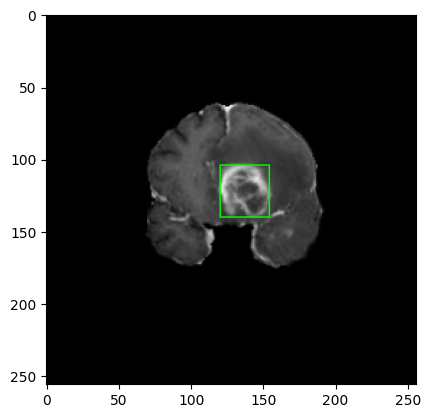

In [ ]:
with open(os.path.join('coronal_dataset/labels/train', f'{random_file}.txt'),'r') as f:
    labels = f.readlines()
    labels = labels[0].split(' ')
    f.close()

img = cv2.imread(os.path.join('coronal_dataset/images/train', f'{random_file}.jpg'), 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

tumor_class, x, y, w, h = int(labels[0]), float(labels[1]), float(labels[2]), float(labels[3]), float(labels[4])
x_pt1 = int((x - w/2) * img.shape[1])
y_pt1 = int((y - h/2) * img.shape[0])
x_pt2 = int((x + w/2) * img.shape[1])
y_pt2 = int((y + h/2) * img.shape[0])

if tumor_class == 1:
    colour = (255, 0, 0)
else:
    colour = (0, 255, 0)
cv2.rectangle(img, (x_pt1, y_pt1), (x_pt2, y_pt2), colour, 1)

print(img.shape)
plt.imshow(img)

**inisiasi directory images dan labels dari folder train dan test**

**Menampilkan jumlah isi dari masing-masing folder**

In [ ]:
coronal_train_images = os.listdir('coronal_dataset/images/train')
coronal_test_images = os.listdir('coronal_dataset/images/test')
coronal_train_labels = os.listdir('coronal_dataset/labels/train')
coronal_test_labels = os.listdir('coronal_dataset/labels/test')

coronal_num_train_images = len(coronal_train_images)
coronal_num_test_images = len(coronal_test_images)
coronal_num_train_labels = len(coronal_train_labels)
coronal_num_test_labels = len(coronal_test_labels)

print(coronal_num_train_images, coronal_num_test_images)
print(coronal_num_train_labels, coronal_num_test_labels)

319 78
318 78


**Terdapat ketidakseimbangan antara jumlah image dan jumlah label pada folder train,**

**oleh karena itu dilakukan penghapusan image yang tidak berlabel.**

In [ ]:
os.path.splitext(random_file)[0]
unlabelled = set(coronal_train_images) - set([os.path.splitext(file)[0] + '.jpg' for file in coronal_train_labels])

for image in unlabelled:
    os.remove(os.path.join('coronal_dataset/images/train', image))

**Menampilkan jumlah isi dari masing-masing folder pasca penghapusan**

In [ ]:
coronal_train_images = os.listdir('coronal_dataset/images/train')
coronal_test_images = os.listdir('coronal_dataset/images/test')
coronal_train_labels = os.listdir('coronal_dataset/labels/train')
coronal_test_labels = os.listdir('coronal_dataset/labels/test')

coronal_num_train_images = len(coronal_train_images)
coronal_num_test_images = len(coronal_test_images)
coronal_num_train_labels = len(coronal_train_labels)
coronal_num_test_labels = len(coronal_test_labels)

print(coronal_num_train_images, coronal_num_test_images)
print(coronal_num_train_labels, coronal_num_test_labels)

318 78
318 78


In [ ]:
val_split = int(coronal_num_train_images * 0.2)
val_images = random.sample(coronal_train_images, val_split)

if os.path.exists('coronal_dataset/images/val'):
    shutil.rmtree('coronal_dataset/images/val')
if os.path.exists('coronal_dataset/labels/val'):
    shutil.rmtree('coronal_dataset/labels/val')

os.mkdir('./coronal_dataset/images/val')
os.mkdir('./coronal_dataset/labels/val')

for image in val_images:
    shutil.move(os.path.join('coronal_dataset/images/train', image), 'coronal_dataset/images/val')

for image in val_images:
    label = os.path.splitext(image)[0] + '.txt'
    shutil.move(os.path.join('coronal_dataset/labels/train', label), 'coronal_dataset/labels/val')

**Membuat data yaml berisi dictionary label**

In [ ]:
text = """
path: /content/coronal_dataset
train: images/train
val: images/val

# Classes
nc: 2
names: ['negative','positive']
"""
with open("./coronal_fixed_path.yaml", 'w') as file:
    file.write(text)

### Model Training

In [ ]:
model = YOLO('yolov8s.pt')

**Melakukan training model**

In [ ]:
wandb.init(mode="disabled")

In [ ]:
coronal_results = model.train(data='/content/coronal_fixed_path.yaml', epochs=200, device=0)

Ultralytics YOLOv8.0.231 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/coronal_fixed_path.yaml, epochs=200, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, li

train: Scanning /content/coronal_dataset/labels/train... 255 images, 0 backgrounds, 0 corrupt: 100%|██████████| 255/255 [00:00<00:00, 1908.62it/s]

train: New cache created: /content/coronal_dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/coronal_dataset/labels/val... 63 images, 0 backgrounds, 0 corrupt: 100%|██████████| 63/63 [00:00<00:00, 861.72it/s]

val: New cache created: /content/coronal_dataset/labels/val.cache


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      4.28G      1.787      6.092      1.494         23        640: 100%|██████████| 16/16 [00:07<00:00,  2.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]

                   all         63         66      0.212      0.288      0.179      0.119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      4.56G      1.305      2.631      1.182         24        640: 100%|██████████| 16/16 [00:05<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]

                   all         63         66       0.26     0.0607      0.111     0.0705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      4.58G      1.207      1.941      1.128         24        640: 100%|██████████| 16/16 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.71it/s]

                   all         63         66     0.0108      0.245    0.00973    0.00609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      4.58G      1.197      1.886      1.157         29        640: 100%|██████████| 16/16 [00:04<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]

                   all         63         66     0.0414      0.615     0.0384     0.0251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      4.59G      1.207      1.673      1.172         26        640: 100%|██████████| 16/16 [00:05<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]

                   all         63         66     0.0884      0.227     0.0517     0.0127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      4.58G      1.278      1.746      1.179         22        640: 100%|██████████| 16/16 [00:05<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all         63         66     0.0884      0.227     0.0517     0.0127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      4.57G      1.241      1.532      1.144         18        640: 100%|██████████| 16/16 [00:04<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.55it/s]

                   all         63         66   0.000314     0.0147   3.97e-05   3.97e-06



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      4.58G      1.197      1.517       1.12         27        640: 100%|██████████| 16/16 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.71it/s]

                   all         63         66     0.0138     0.0303    0.00192   0.000921



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      4.58G      1.173      1.494       1.15         21        640: 100%|██████████| 16/16 [00:05<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.48it/s]

                   all         63         66      0.276      0.196      0.105     0.0507



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      4.58G      1.133       1.33      1.089         14        640: 100%|██████████| 16/16 [00:04<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]

                   all         63         66       0.23     0.0607     0.0302    0.00948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      4.58G       1.15      1.342       1.09         30        640: 100%|██████████| 16/16 [00:05<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.97it/s]

                   all         63         66      0.165      0.672      0.168      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      4.58G      1.106      1.295      1.055         23        640: 100%|██████████| 16/16 [00:04<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.64it/s]

                   all         63         66      0.348      0.676      0.507      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      4.58G      1.133      1.296      1.092         32        640: 100%|██████████| 16/16 [00:05<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.82it/s]

                   all         63         66      0.436      0.924      0.503       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      4.74G      1.081      1.342      1.078         19        640: 100%|██████████| 16/16 [00:04<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]

                   all         63         66      0.151      0.681      0.173      0.107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      4.58G      1.119      1.254      1.111         14        640: 100%|██████████| 16/16 [00:04<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]

                   all         63         66      0.391      0.874      0.528      0.364



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      4.58G      1.108      1.268      1.068         20        640: 100%|██████████| 16/16 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]

                   all         63         66      0.438      0.925      0.558      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      4.57G      1.135      1.269      1.088         24        640: 100%|██████████| 16/16 [00:04<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]

                   all         63         66      0.424      0.785      0.589        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      4.74G      1.025      1.207      1.041         19        640: 100%|██████████| 16/16 [00:04<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.58it/s]

                   all         63         66       0.43      0.847      0.543      0.372



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      4.57G      1.013      1.171      1.026         21        640: 100%|██████████| 16/16 [00:04<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.83it/s]

                   all         63         66      0.428      0.866      0.538        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      4.58G      1.001      1.182      1.021         23        640: 100%|██████████| 16/16 [00:05<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.72it/s]

                   all         63         66      0.485       0.91      0.585      0.401



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      4.57G      1.006      1.141      1.038         25        640: 100%|██████████| 16/16 [00:04<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]

                   all         63         66      0.438      0.832      0.594      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      4.58G       1.03      1.149      1.043         16        640: 100%|██████████| 16/16 [00:05<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]

                   all         63         66       0.48      0.897      0.615       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      4.57G      1.027      1.075      1.035         16        640: 100%|██████████| 16/16 [00:04<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]

                   all         63         66      0.486      0.884      0.597      0.428



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      4.58G      1.082      1.151      1.056         18        640: 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]

                   all         63         66      0.516      0.808      0.636      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      4.57G      1.027      1.164      1.033         21        640: 100%|██████████| 16/16 [00:04<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.01it/s]

                   all         63         66      0.521      0.802      0.664      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      4.58G      1.045      1.156      1.039         20        640: 100%|██████████| 16/16 [00:05<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.15it/s]

                   all         63         66      0.575      0.717      0.717      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      4.57G      1.023      1.119      1.044         24        640: 100%|██████████| 16/16 [00:04<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

                   all         63         66      0.529      0.858      0.681       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      4.57G     0.9787      1.088      1.015         21        640: 100%|██████████| 16/16 [00:04<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.28it/s]

                   all         63         66      0.482      0.939       0.67       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      4.57G      0.979      1.082      1.013         24        640: 100%|██████████| 16/16 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]

                   all         63         66      0.532       0.81      0.678       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      4.58G      1.004      1.123      1.041         15        640: 100%|██████████| 16/16 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all         63         66      0.526      0.832      0.704      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      4.57G     0.9968      1.055      1.038         24        640: 100%|██████████| 16/16 [00:05<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.61it/s]

                   all         63         66        0.5      0.849      0.628      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      4.74G       0.95      1.037      1.019         28        640: 100%|██████████| 16/16 [00:04<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.75it/s]

                   all         63         66      0.578      0.687      0.648      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      4.57G      0.902      1.049     0.9868         23        640: 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.07it/s]

                   all         63         66      0.541      0.859      0.742      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      4.58G     0.9426      1.048      1.019         28        640: 100%|██████████| 16/16 [00:04<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.73it/s]

                   all         63         66      0.627      0.766       0.75      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      4.57G     0.9446      1.051      1.017         25        640: 100%|██████████| 16/16 [00:05<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]

                   all         63         66      0.649      0.855      0.778      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      4.58G     0.9717      1.106      1.046         23        640: 100%|██████████| 16/16 [00:04<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all         63         66      0.479      0.924       0.71      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      4.57G      0.917      1.071     0.9819         35        640: 100%|██████████| 16/16 [00:04<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.69it/s]

                   all         63         66      0.506      0.902      0.692      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      4.58G     0.9331      1.035      1.014         21        640: 100%|██████████| 16/16 [00:04<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.75it/s]

                   all         63         66      0.621      0.696      0.701      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      4.57G     0.9282      1.084       1.01         18        640: 100%|██████████| 16/16 [00:04<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.97it/s]

                   all         63         66        0.7      0.814      0.845      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      4.58G     0.9784       1.05      1.017         22        640: 100%|██████████| 16/16 [00:05<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.34it/s]

                   all         63         66      0.681      0.788      0.784      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      4.57G     0.9104      1.001     0.9806         19        640: 100%|██████████| 16/16 [00:04<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.41it/s]

                   all         63         66      0.577      0.823       0.69      0.521



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      4.58G     0.8757     0.9257     0.9649         20        640: 100%|██████████| 16/16 [00:06<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.03it/s]

                   all         63         66      0.646      0.821      0.798      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      4.57G      0.902      1.008     0.9861         33        640: 100%|██████████| 16/16 [00:04<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.33it/s]

                   all         63         66       0.52      0.756      0.621      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      4.58G     0.8726     0.9639     0.9633         15        640: 100%|██████████| 16/16 [00:05<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]

                   all         63         66      0.605      0.761      0.751      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      4.57G     0.9148     0.9877     0.9922         22        640: 100%|██████████| 16/16 [00:04<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.46it/s]

                   all         63         66      0.766      0.717      0.826      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      4.58G     0.8564      0.953     0.9714         16        640: 100%|██████████| 16/16 [00:04<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.30it/s]

                   all         63         66      0.681      0.799      0.795       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      4.57G     0.8952     0.9671     0.9808         23        640: 100%|██████████| 16/16 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.97it/s]

                   all         63         66      0.517      0.879      0.738       0.55



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      4.58G     0.9308     0.9834      1.014         16        640: 100%|██████████| 16/16 [00:04<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]

                   all         63         66      0.717      0.759      0.816      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      4.57G     0.8938     0.9076     0.9903         25        640: 100%|██████████| 16/16 [00:05<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.36it/s]

                   all         63         66       0.61      0.805      0.809      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      4.74G     0.8772     0.8814     0.9677         15        640: 100%|██████████| 16/16 [00:04<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]

                   all         63         66      0.707      0.816       0.84      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      4.57G     0.8778     0.8796     0.9768         18        640: 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]

                   all         63         66      0.711      0.861       0.86      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      4.58G      0.855     0.9153     0.9647         26        640: 100%|██████████| 16/16 [00:04<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.47it/s]

                   all         63         66      0.775      0.772      0.845      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      4.73G     0.8808     0.9174     0.9794         21        640: 100%|██████████| 16/16 [00:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.19it/s]

                   all         63         66      0.637      0.892      0.834      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      4.58G     0.8793     0.8694     0.9663         24        640: 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.67it/s]

                   all         63         66       0.68      0.862      0.859      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      4.57G     0.8599     0.8914     0.9632         23        640: 100%|██████████| 16/16 [00:04<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]

                   all         63         66      0.608      0.815      0.739      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      4.58G     0.8315     0.8287     0.9503         24        640: 100%|██████████| 16/16 [00:04<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.55it/s]

                   all         63         66      0.735      0.774       0.83      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      4.57G     0.8402     0.8883     0.9575         16        640: 100%|██████████| 16/16 [00:04<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.72it/s]

                   all         63         66      0.803      0.844      0.859      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      4.58G     0.8253     0.8517     0.9645         26        640: 100%|██████████| 16/16 [00:04<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.30it/s]

                   all         63         66       0.68      0.877      0.829      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      4.57G     0.8557     0.7987     0.9497         23        640: 100%|██████████| 16/16 [00:04<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.65it/s]

                   all         63         66      0.614      0.776      0.755       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      4.58G     0.8274     0.8575     0.9701         23        640: 100%|██████████| 16/16 [00:06<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         63         66      0.665      0.896      0.871       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      4.57G      0.857       0.89     0.9679         17        640: 100%|██████████| 16/16 [00:04<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.73it/s]

                   all         63         66      0.761      0.817       0.85       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      4.58G      0.788     0.7869     0.9517         25        640: 100%|██████████| 16/16 [00:05<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]

                   all         63         66      0.727      0.819       0.84      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      4.57G     0.9042     0.8684      1.002         19        640: 100%|██████████| 16/16 [00:04<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.98it/s]

                   all         63         66      0.787      0.736      0.838       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      4.58G     0.8084     0.7739     0.9631         16        640: 100%|██████████| 16/16 [00:04<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]

                   all         63         66      0.792      0.745      0.821      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      4.57G     0.8274     0.7913       0.94         26        640: 100%|██████████| 16/16 [00:04<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.58it/s]

                   all         63         66      0.693      0.845      0.863      0.659



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      4.58G     0.7809     0.7968     0.9099         15        640: 100%|██████████| 16/16 [00:04<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]

                   all         63         66      0.658       0.87       0.82      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      4.57G     0.8187     0.7787     0.9348         19        640: 100%|██████████| 16/16 [00:05<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

                   all         63         66      0.852      0.755      0.877      0.677



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      4.58G     0.8379     0.7986     0.9405         27        640: 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.69it/s]

                   all         63         66      0.766      0.869       0.88      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      4.57G     0.7563     0.7516     0.9406         23        640: 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         63         66      0.731      0.831        0.8       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      4.58G     0.7969     0.7416     0.9475         21        640: 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.58it/s]

                   all         63         66       0.74      0.799      0.827      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      4.57G     0.8017     0.7089     0.9544         25        640: 100%|██████████| 16/16 [00:05<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all         63         66      0.674      0.829      0.766      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      4.58G     0.7774     0.6662     0.9295         27        640: 100%|██████████| 16/16 [00:04<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.94it/s]

                   all         63         66      0.924      0.869      0.922      0.713



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      4.73G     0.8027     0.6654     0.9268         29        640: 100%|██████████| 16/16 [00:04<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]

                   all         63         66       0.83      0.866      0.912      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      4.58G     0.7893       0.68     0.9352         17        640: 100%|██████████| 16/16 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]

                   all         63         66      0.729      0.761      0.804        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      4.57G     0.7662     0.6971     0.9353         24        640: 100%|██████████| 16/16 [00:04<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.71it/s]

                   all         63         66      0.721       0.92       0.82      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      4.58G      0.772     0.6516     0.9447         24        640: 100%|██████████| 16/16 [00:05<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.37it/s]

                   all         63         66      0.734      0.745      0.816      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      4.57G       0.82     0.7384     0.9608         16        640: 100%|██████████| 16/16 [00:04<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]

                   all         63         66      0.751      0.909      0.882       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      4.57G     0.7645     0.6679     0.9157         25        640: 100%|██████████| 16/16 [00:05<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]

                   all         63         66      0.792      0.829      0.908      0.704



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      4.57G     0.7501     0.7335     0.9211         23        640: 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]

                   all         63         66      0.861      0.835      0.884      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      4.74G     0.7412      0.696     0.9198         23        640: 100%|██████████| 16/16 [00:04<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.38it/s]

                   all         63         66      0.771       0.83      0.846       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      4.57G     0.7658     0.6592     0.9241         23        640: 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]

                   all         63         66      0.887      0.802      0.887      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      4.58G     0.7779     0.6305     0.9468         22        640: 100%|██████████| 16/16 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         63         66      0.833      0.782      0.881      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      4.57G     0.8038     0.6535     0.9508         24        640: 100%|██████████| 16/16 [00:05<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         63         66      0.818      0.799      0.854      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      4.58G       0.75     0.6494     0.9156         23        640: 100%|██████████| 16/16 [00:04<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]

                   all         63         66      0.826      0.796      0.856      0.652



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      4.57G     0.7325     0.6087     0.9118         27        640: 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         63         66      0.776      0.864      0.877       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      4.58G     0.7531     0.6268     0.9179         23        640: 100%|██████████| 16/16 [00:04<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.69it/s]

                   all         63         66      0.755      0.922      0.857      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      4.57G     0.7529     0.6468     0.9232         30        640: 100%|██████████| 16/16 [00:05<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         63         66      0.717      0.908      0.846      0.663



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      4.58G     0.7341     0.6061     0.9041         27        640: 100%|██████████| 16/16 [00:04<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.72it/s]

                   all         63         66       0.73      0.846      0.802        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      4.57G     0.7343     0.6419     0.9169         24        640: 100%|██████████| 16/16 [00:04<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.62it/s]

                   all         63         66      0.784      0.803      0.876      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      4.58G     0.7264     0.6075     0.9133         31        640: 100%|██████████| 16/16 [00:04<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.34it/s]

                   all         63         66       0.78      0.827       0.87      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      4.57G     0.6951     0.5971     0.9102         30        640: 100%|██████████| 16/16 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]

                   all         63         66      0.774      0.801      0.846      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      4.58G     0.6983     0.5497     0.9192         18        640: 100%|██████████| 16/16 [00:05<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]

                   all         63         66      0.818      0.818      0.891      0.675



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      4.57G     0.7232       0.59      0.922         30        640: 100%|██████████| 16/16 [00:04<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]

                   all         63         66      0.636      0.815      0.791      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      4.57G      0.748     0.6219     0.9221         18        640: 100%|██████████| 16/16 [00:05<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]

                   all         63         66      0.789      0.907      0.904      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      4.57G     0.7146     0.5976      0.919         26        640: 100%|██████████| 16/16 [00:04<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]

                   all         63         66      0.804      0.866      0.883      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      4.58G     0.6732     0.5728     0.9109         25        640: 100%|██████████| 16/16 [00:04<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]

                   all         63         66      0.773      0.889      0.893      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      4.57G     0.7075     0.5808     0.9165         23        640: 100%|██████████| 16/16 [00:04<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.28it/s]

                   all         63         66      0.704      0.849      0.858      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      4.58G     0.7538     0.5877     0.9251         23        640: 100%|██████████| 16/16 [00:04<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         63         66      0.776       0.83      0.874      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      4.57G     0.6705     0.5507     0.8885         26        640: 100%|██████████| 16/16 [00:05<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]

                   all         63         66      0.855       0.79      0.862      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      4.58G     0.7446     0.5739     0.9264         32        640: 100%|██████████| 16/16 [00:04<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.75it/s]

                   all         63         66      0.813      0.816      0.848      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      4.57G     0.7196     0.6048     0.9088         23        640: 100%|██████████| 16/16 [00:05<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]

                   all         63         66      0.814      0.726      0.806       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      4.58G     0.7164     0.5697     0.9353         18        640: 100%|██████████| 16/16 [00:04<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]

                   all         63         66      0.811      0.716       0.81      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      4.57G      0.705      0.583      0.911         23        640: 100%|██████████| 16/16 [00:05<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.39it/s]

                   all         63         66      0.798      0.881      0.864      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      4.58G     0.6799     0.5553     0.9019         31        640: 100%|██████████| 16/16 [00:04<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]

                   all         63         66      0.748      0.825      0.857      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      4.57G     0.7122     0.5287     0.9057         13        640: 100%|██████████| 16/16 [00:04<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.66it/s]

                   all         63         66      0.803      0.798      0.865      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      4.58G     0.6699     0.5334     0.9074         23        640: 100%|██████████| 16/16 [00:05<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]

                   all         63         66      0.703       0.79      0.806       0.62



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      4.57G      0.732     0.5709     0.9385         26        640: 100%|██████████| 16/16 [00:04<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.30it/s]

                   all         63         66      0.653      0.853      0.771       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      4.58G        0.7     0.5691     0.9107         26        640: 100%|██████████| 16/16 [00:05<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]

                   all         63         66        0.8      0.757      0.838      0.654



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      4.57G     0.6623     0.5304     0.8894         21        640: 100%|██████████| 16/16 [00:04<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]

                   all         63         66      0.703      0.904      0.852      0.662



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      4.58G     0.6637     0.5432     0.9027         20        640: 100%|██████████| 16/16 [00:05<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.44it/s]

                   all         63         66      0.759      0.768      0.831      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      4.57G     0.6657     0.5183     0.8937         18        640: 100%|██████████| 16/16 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.53it/s]

                   all         63         66      0.726      0.842      0.825      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      4.58G     0.6671     0.5238     0.9101         21        640: 100%|██████████| 16/16 [00:04<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all         63         66      0.825      0.808      0.868      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      4.57G     0.6841     0.5586     0.9286         16        640: 100%|██████████| 16/16 [00:04<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]

                   all         63         66      0.784      0.886      0.895        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      4.58G     0.6588     0.5088     0.9023         23        640: 100%|██████████| 16/16 [00:04<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]

                   all         63         66      0.816      0.853      0.886      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      4.57G     0.6324     0.5176     0.8837         20        640: 100%|██████████| 16/16 [00:05<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]

                   all         63         66      0.814      0.804      0.816      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      4.58G     0.6488     0.5079     0.8821         23        640: 100%|██████████| 16/16 [00:04<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.70it/s]

                   all         63         66      0.777      0.783      0.841      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      4.57G     0.6756     0.5123     0.9005         19        640: 100%|██████████| 16/16 [00:06<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         63         66       0.82      0.787      0.884      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      4.58G     0.6394     0.4941     0.8951         29        640: 100%|██████████| 16/16 [00:04<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]

                   all         63         66       0.86      0.861      0.897      0.686



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      4.57G     0.6542     0.4837     0.8868         21        640: 100%|██████████| 16/16 [00:05<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all         63         66      0.809      0.877      0.862      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      4.58G     0.6847       0.53      0.895         33        640: 100%|██████████| 16/16 [00:04<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]

                   all         63         66      0.795      0.825      0.831      0.645



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      4.57G     0.7358     0.5078     0.9081         22        640: 100%|██████████| 16/16 [00:04<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]

                   all         63         66      0.744      0.887      0.862      0.678



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      4.74G     0.6497     0.4776     0.8913         26        640: 100%|██████████| 16/16 [00:05<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.46it/s]

                   all         63         66      0.772      0.818      0.841      0.643
Stopping training early as no improvement observed in last 50 epochs. Best results observed at epoch 72, best model saved as best.pt.
To update EarlyStopping(patience=50) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



122 epochs completed in 0.230 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 22.5MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics YOLOv8.0.231 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11126358 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]


                   all         63         66      0.924      0.868      0.921      0.712
              negative         63         34      0.885      0.903       0.93      0.755
              positive         63         32      0.964      0.834      0.912       0.67
Speed: 0.3ms preprocess, 5.4ms inference, 0.0ms loss, 2.0ms postprocess per image
Results saved to runs/detect/train2


**Menampilkan Board Training**

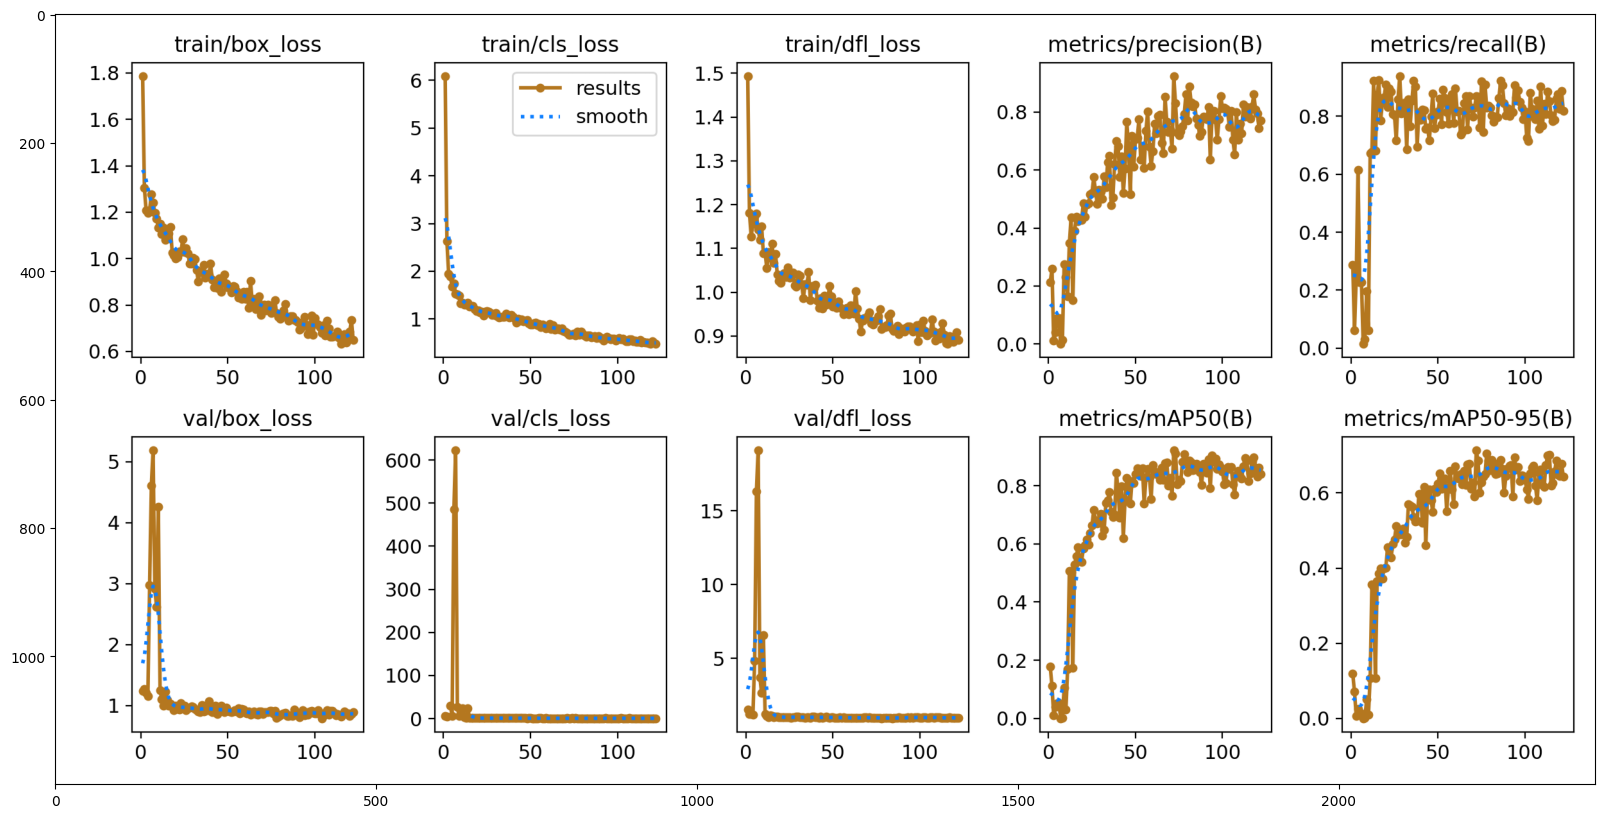

In [ ]:
coronal_training_save_dir = '/content/' + str(coronal_results.save_dir)

plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(coronal_training_save_dir, 'results.png'))
plt.imshow(img)
plt.show()

**Menampilkan Confusion Matrix hasil training**

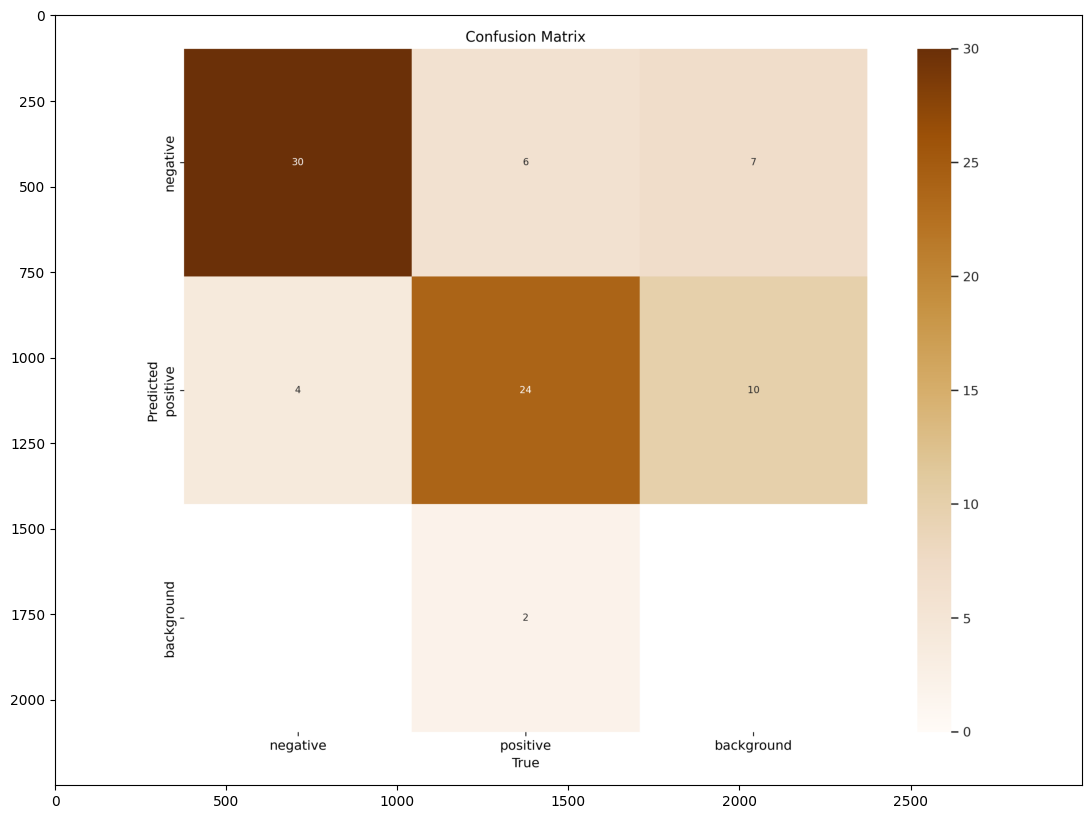

In [ ]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(coronal_training_save_dir, 'confusion_matrix.png'))
plt.imshow(img)
plt.show()

**Menampilkan hasil training**

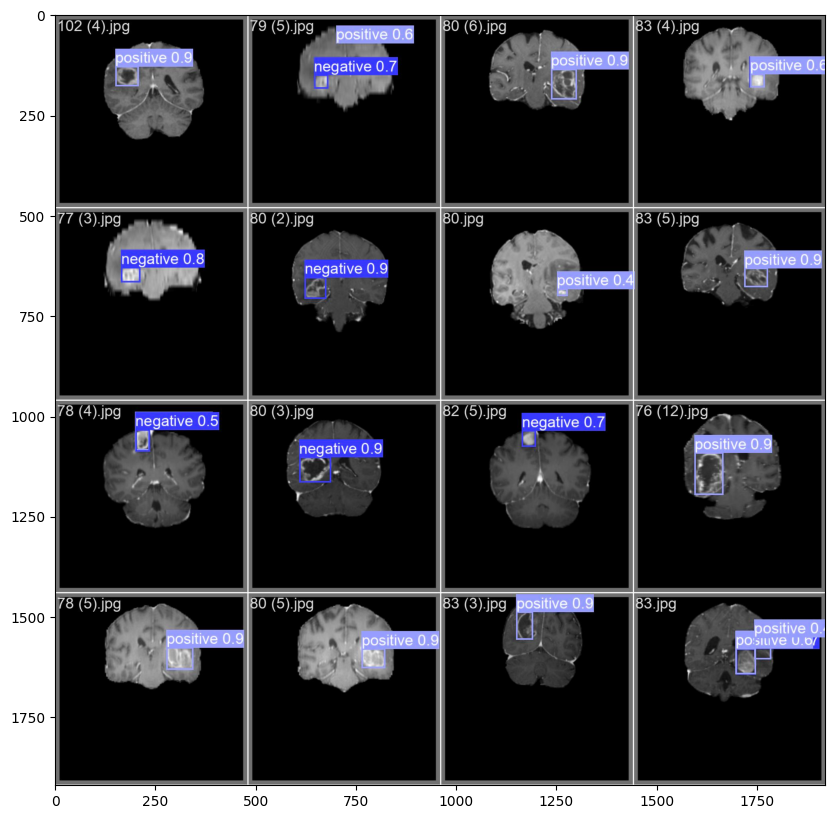

In [ ]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(coronal_training_save_dir, 'val_batch0_pred.jpg'))
plt.imshow(img)
plt.show()

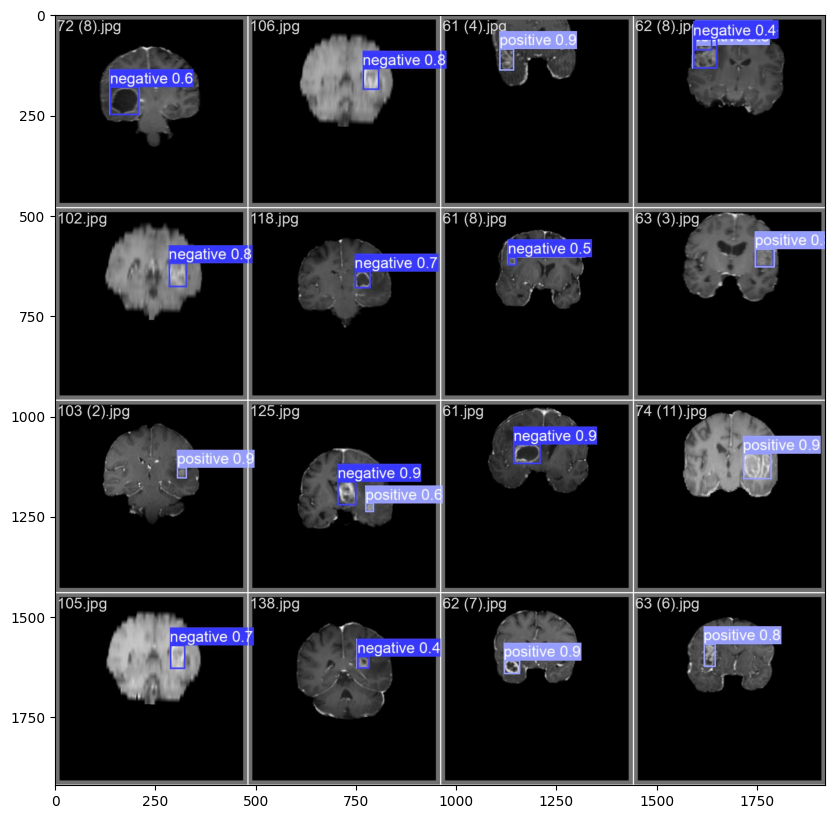

In [ ]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(coronal_training_save_dir, 'val_batch1_pred.jpg'))
plt.imshow(img)
plt.show()

### Prediction / Testing

**Mengimplementasikan hasil training model ke test folder**

In [ ]:
coronal_trained_model = YOLO(coronal_training_save_dir + '/weights/best.pt')
coronal_predictions = coronal_trained_model.predict(
    source="/content/brain-tumor-object-detection-datasets/coronal_t1wce_2_class/images/test",
    conf=0.4, save_txt=True, save_conf=True)


image 1/78 /content/brain-tumor-object-detection-datasets/coronal_t1wce_2_class/images/test/13.jpg: 640x640 (no detections), 16.0ms
image 2/78 /content/brain-tumor-object-detection-datasets/coronal_t1wce_2_class/images/test/15.jpg: 640x640 1 positive, 16.0ms
image 3/78 /content/brain-tumor-object-detection-datasets/coronal_t1wce_2_class/images/test/17.jpg: 640x640 1 positive, 16.0ms
image 4/78 /content/brain-tumor-object-detection-datasets/coronal_t1wce_2_class/images/test/19.jpg: 640x640 1 negative, 15.9ms
image 5/78 /content/brain-tumor-object-detection-datasets/coronal_t1wce_2_class/images/test/20.jpg: 640x640 1 positive, 15.9ms
image 6/78 /content/brain-tumor-object-detection-datasets/coronal_t1wce_2_class/images/test/23.jpg: 640x640 1 negative, 1 positive, 16.0ms
image 7/78 /content/brain-tumor-object-detection-datasets/coronal_t1wce_2_class/images/test/33.jpg: 640x640 1 positive, 16.0ms
image 8/78 /content/brain-tumor-object-detection-datasets/coronal_t1wce_2_class/images/test/3

In [ ]:
coronal_predictions_save_dir = '/content/' + coronal_predictions[0].save_dir + '/labels'

In [ ]:
text = """
path: /content/coronal_dataset
train: images/train
val: images/test

# Classes
nc: 2
names: ['negative','positive']
"""
with open("./coronal_test.yaml", 'w') as file:
    file.write(text)

In [ ]:
coronal_metrics = coronal_trained_model.val(data="coronal_test.yaml")  # no arguments needed, dataset and settings remembered

Ultralytics YOLOv8.0.231 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/coronal_dataset/labels/test... 78 images, 0 backgrounds, 0 corrupt: 100%|██████████| 78/78 [00:00<00:00, 746.37it/s]

val: New cache created: /content/coronal_dataset/labels/test.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.38it/s]


                   all         78         83      0.457      0.855      0.539      0.389
              negative         78         34      0.394      0.853      0.514      0.395
              positive         78         49      0.521      0.857      0.564      0.382
Speed: 1.8ms preprocess, 14.0ms inference, 0.0ms loss, 5.6ms postprocess per image
Results saved to runs/detect/val2


**Menampilkan Confusion Matrix hasil testing**

In [ ]:
coronal_test_save_dir = '/content/' + str(coronal_metrics.save_dir)

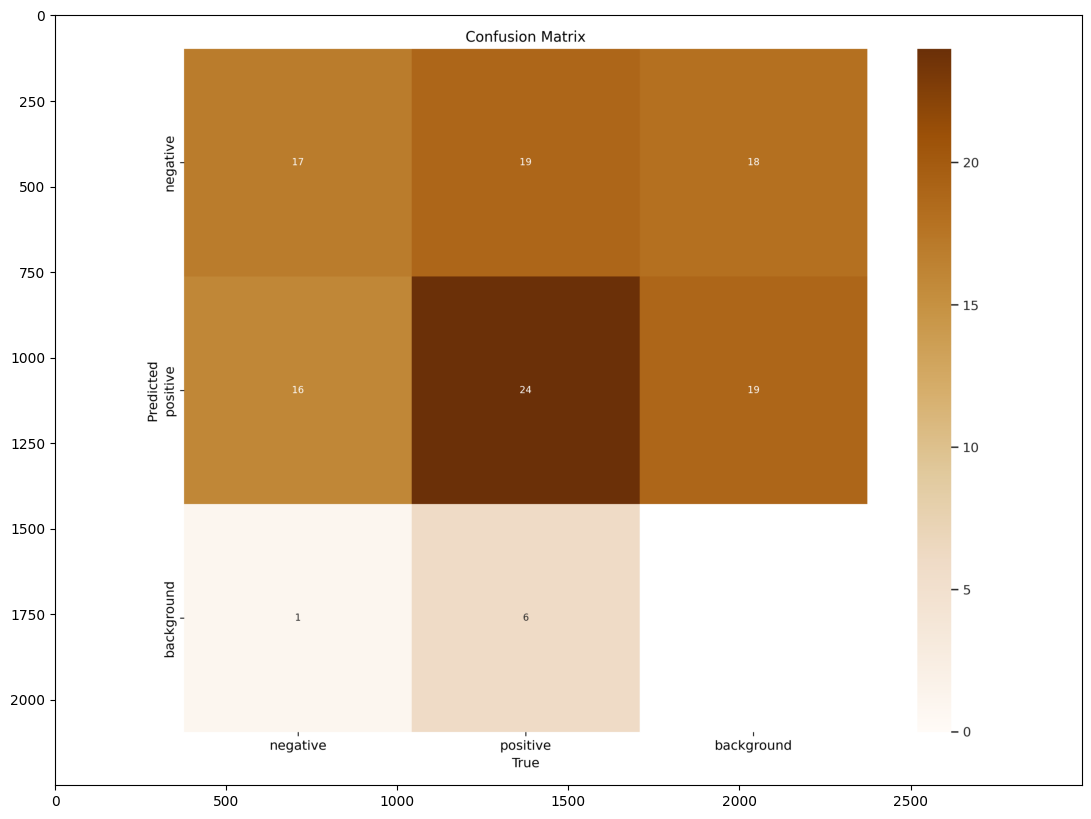

In [ ]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(coronal_test_save_dir, 'confusion_matrix.png'))
plt.imshow(img)
plt.show()

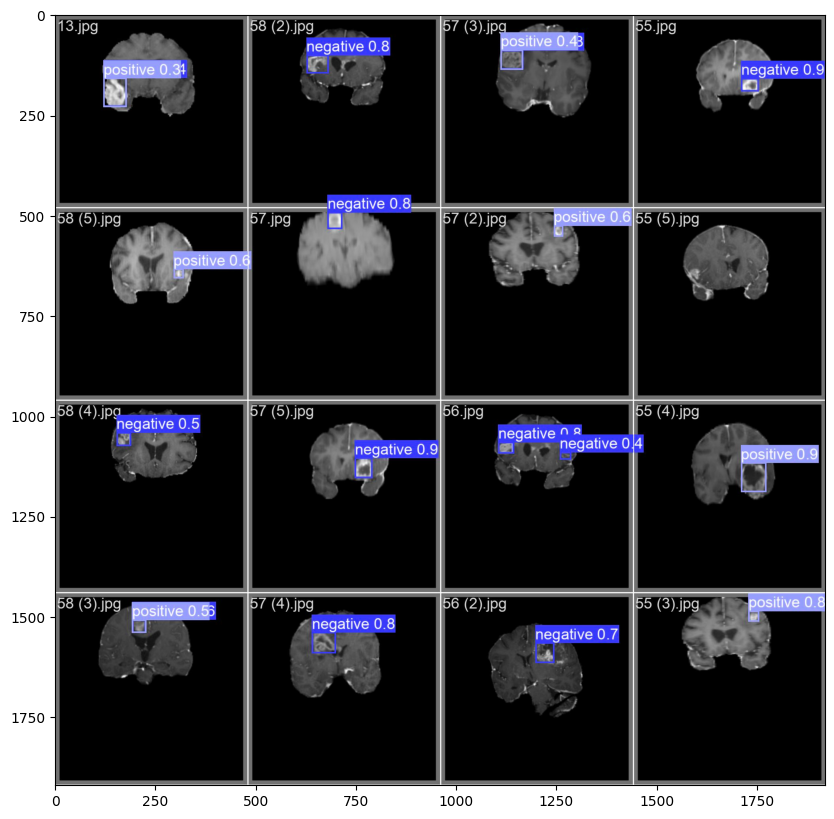

In [ ]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(coronal_test_save_dir, 'val_batch0_pred.jpg'))
plt.imshow(img)
plt.show()

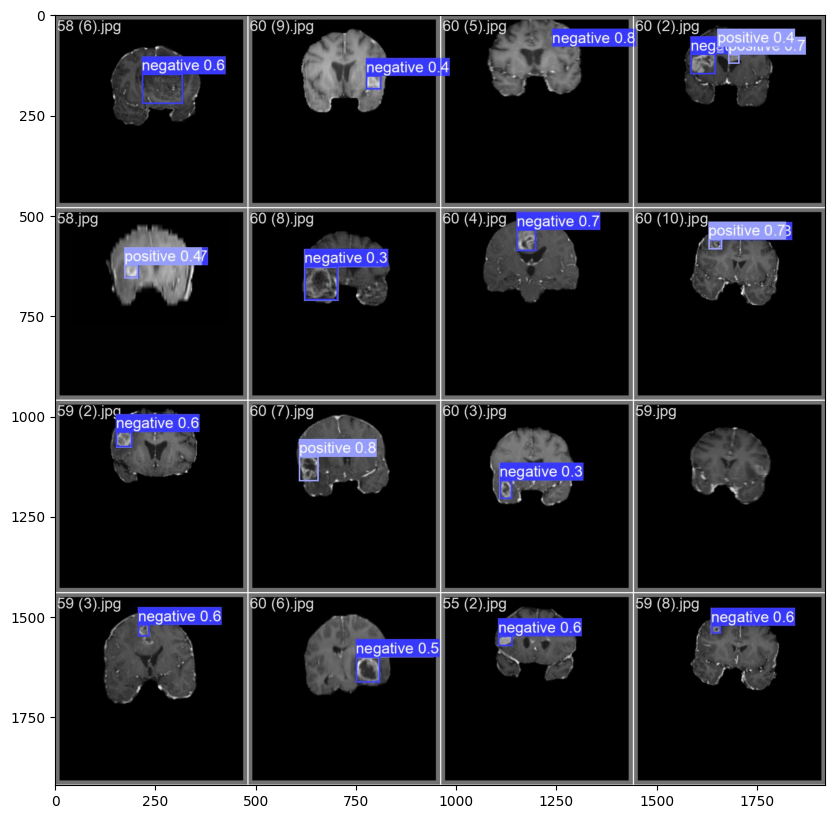

In [ ]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(coronal_test_save_dir, 'val_batch1_pred.jpg'))
plt.imshow(img)
plt.show()

### Compare (repeatable)

['1', '0.330113', '0.234863', '0.0812876', '0.0618805', '0.826779\n']
['0', '0.332746', '0.235329', '0.085681', '0.059859']


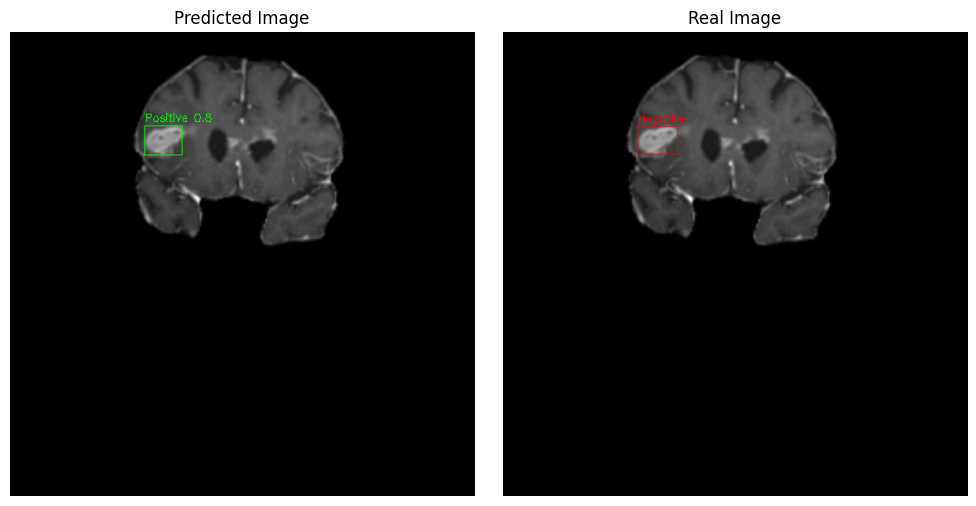

In [ ]:
def draw_bbox(file_path, filename, img):
    with open(os.path.join(file_path, f'{filename}.txt'),'r') as f:
        labels = f.readlines()
        labels = labels[0].split(' ')
        print(labels)
        f.close()

    tumor_class, x, y, w, h = int(labels[0]), float(labels[1]), float(labels[2]), float(labels[3]), float(labels[4])
    x_pt1 = int((x - w/2) * img.shape[1])
    y_pt1 = int((y - h/2) * img.shape[0])
    x_pt2 = int((x + w/2) * img.shape[1])
    y_pt2 = int((y + h/2) * img.shape[0])

    if tumor_class == 0:
        colour = (255, 0, 0)
        label = 'Negative'
    else:
        colour = (0, 255, 0)
        label = 'Positive'
    if len(labels) > 5:
        prob = float(labels[5])
        prob = round(prob, 1)
        prob = str(prob)
        label = label + ' ' + prob

    cv2.rectangle(img, (x_pt1, y_pt1), (x_pt2, y_pt2), colour, 1)
    cv2.putText(img, label, (x_pt1, y_pt1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, colour, 1)

files = os.listdir(coronal_predictions_save_dir)
random_file = random.choice(files)
random_file = os.path.splitext(random_file)[0]

img_pred = cv2.imread(os.path.join('coronal_dataset/images/test', f'{random_file}.jpg'), 1)
img_pred = cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)
draw_bbox(coronal_predictions_save_dir, random_file, img_pred)

img_real = cv2.imread(os.path.join('coronal_dataset/images/test', f'{random_file}.jpg'), 1)
img_real = cv2.cvtColor(img_real, cv2.COLOR_BGR2RGB)
draw_bbox('coronal_dataset/labels/test', random_file, img_real)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img_pred)
axes[0].set_title('Predicted Image')
axes[0].axis('off')

axes[1].imshow(img_real)
axes[1].set_title('Real Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()

## **Sagittal Dataset**

### Pre-processing

**Inisiasi coronal_t1wce_2_class menjadi coronal_dataset**

In [ ]:
if os.path.exists('sagittal_dataset'):
    shutil.rmtree('sagittal_dataset')
shutil.copytree('/content/brain-tumor-object-detection-datasets/sagittal_t1wce_2_class/', 'sagittal_dataset')

'sagittal_dataset'

**Memanggil satu image dari folder train secara random**

In [ ]:
files = os.listdir('sagittal_dataset/images/train')
random_file = random.choice(files)
random_file = os.path.splitext(random_file)[0]
print(random_file)

00183_144


**Menampilkan random image tersebut**

(512, 512, 3)


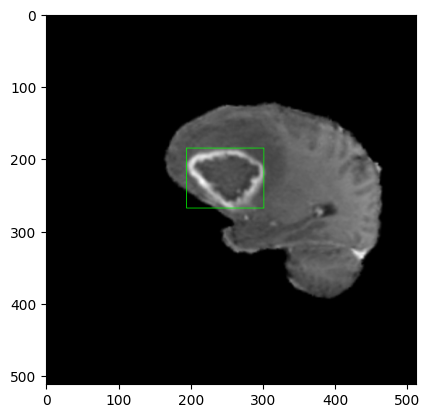

In [ ]:
with open(os.path.join('sagittal_dataset/labels/train', f'{random_file}.txt'),'r') as f:
    labels = f.readlines()
    labels = labels[0].split(' ')
    f.close()

img = cv2.imread(os.path.join('sagittal_dataset/images/train', f'{random_file}.jpg'), 1)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

tumor_class, x, y, w, h = int(labels[0]), float(labels[1]), float(labels[2]), float(labels[3]), float(labels[4])
x_pt1 = int((x - w/2) * img.shape[1])
y_pt1 = int((y - h/2) * img.shape[0])
x_pt2 = int((x + w/2) * img.shape[1])
y_pt2 = int((y + h/2) * img.shape[0])

if tumor_class == 1:
    colour = (255, 0, 0)
else:
    colour = (0, 255, 0)
cv2.rectangle(img, (x_pt1, y_pt1), (x_pt2, y_pt2), colour, 1)

print(img.shape)
plt.imshow(img)

**inisiasi directory images dan labels dari folder train dan test**

**Menampilkan jumlah isi dari masing-masing folder**

In [ ]:
sagittal_train_images = os.listdir('sagittal_dataset/images/train')
sagittal_test_images = os.listdir('sagittal_dataset/images/test')
sagittal_train_labels = os.listdir('sagittal_dataset/labels/train')
sagittal_test_labels = os.listdir('sagittal_dataset/labels/test')

sagittal_num_train_images = len(sagittal_train_images)
sagittal_num_test_images = len(sagittal_test_images)
sagittal_num_train_labels = len(sagittal_train_labels)
sagittal_num_test_labels = len(sagittal_test_labels)

print(sagittal_num_train_images, sagittal_num_test_images)
print(sagittal_num_train_labels, sagittal_num_test_labels)

264 70
264 70


In [ ]:
val_split = int(sagittal_num_train_images * 0.2)
val_images = random.sample(sagittal_train_images, val_split)

if os.path.exists('sagittal_dataset/images/val'):
    shutil.rmtree('sagittal_dataset/images/val')
if os.path.exists('sagittal_dataset/labels/val'):
    shutil.rmtree('sagittal_dataset/labels/val')

os.mkdir('./sagittal_dataset/images/val')
os.mkdir('./sagittal_dataset/labels/val')

for image in val_images:
    shutil.move(os.path.join('sagittal_dataset/images/train', image), 'sagittal_dataset/images/val')

for image in val_images:
    label = os.path.splitext(image)[0] + '.txt'
    shutil.move(os.path.join('sagittal_dataset/labels/train', label), 'sagittal_dataset/labels/val')

**Membuat data yaml berisi dictionary label**

In [ ]:
text = """
path: /content/sagittal_dataset
train: images/train
val: images/val

# Classes
nc: 2
names: ['negative','positive']
"""
with open("./sagittal_fixed_path.yaml", 'w') as file:
    file.write(text)

### Model Training

In [ ]:
model = YOLO('yolov8s.pt')

**Melakukan training model**

In [ ]:
wandb.init(mode="disabled")

In [ ]:
sagittal_results = model.train(data='/content/sagittal_fixed_path.yaml', epochs=200, device=0)

Ultralytics YOLOv8.0.231 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8s.pt, data=/content/sagittal_fixed_path.yaml, epochs=200, time=None, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train3, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, l

train: Scanning /content/sagittal_dataset/labels/train... 212 images, 0 backgrounds, 0 corrupt: 100%|██████████| 212/212 [00:00<00:00, 1831.29it/s]

train: New cache created: /content/sagittal_dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/sagittal_dataset/labels/val... 52 images, 0 backgrounds, 0 corrupt: 100%|██████████| 52/52 [00:00<00:00, 890.40it/s]

val: New cache created: /content/sagittal_dataset/labels/val.cache


Plotting labels to runs/detect/train3/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
200 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/200      4.65G      2.002      6.517      1.659         10        640: 100%|██████████| 14/14 [00:06<00:00,  2.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.63it/s]

                   all         52         53     0.0872       0.12     0.0258     0.0128



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/200      4.95G      1.588      3.243      1.359          5        640: 100%|██████████| 14/14 [00:04<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]

                   all         52         53      0.344      0.365      0.289      0.159



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/200      4.96G      1.377      2.466      1.256          6        640: 100%|██████████| 14/14 [00:03<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]

                   all         52         53      0.378      0.383      0.311        0.2



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/200      4.95G      1.256      1.904      1.228          5        640: 100%|██████████| 14/14 [00:04<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.08it/s]

                   all         52         53      0.402      0.425      0.355      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/200      4.95G      1.304      1.895      1.183          3        640: 100%|██████████| 14/14 [00:03<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.36it/s]

                   all         52         53      0.282      0.183      0.181     0.0898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/200      4.95G      1.343      1.781      1.217          3        640: 100%|██████████| 14/14 [00:04<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.87it/s]

                   all         52         53      0.282      0.183      0.181     0.0898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/200      4.95G      1.354       1.76       1.23          6        640: 100%|██████████| 14/14 [00:05<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]

                   all         52         53    0.00196     0.0172    0.00117   0.000938



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/200      4.96G      1.438      1.782      1.252          4        640: 100%|██████████| 14/14 [00:03<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]

                   all         52         53    0.00152      0.159   0.000972   0.000288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/200      4.95G      1.344      1.725      1.224          5        640: 100%|██████████| 14/14 [00:03<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.90it/s]

                   all         52         53      0.293      0.183      0.113     0.0646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/200      4.96G      1.295      1.679      1.203         11        640: 100%|██████████| 14/14 [00:04<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]

                   all         52         53       0.54      0.348      0.416      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/200      4.95G      1.227      1.562      1.134          6        640: 100%|██████████| 14/14 [00:05<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.64it/s]

                   all         52         53      0.509      0.634      0.427      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/200      4.95G      1.371      1.632      1.242          7        640: 100%|██████████| 14/14 [00:04<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.70it/s]

                   all         52         53      0.435       0.54      0.433      0.246



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/200      4.95G      1.306      1.497      1.207          5        640: 100%|██████████| 14/14 [00:04<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]

                   all         52         53      0.506      0.601      0.443      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/200      4.96G      1.306      1.474      1.194         13        640: 100%|██████████| 14/14 [00:05<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.24it/s]

                   all         52         53      0.439      0.578      0.446      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/200      5.11G       1.28      1.488      1.206          6        640: 100%|██████████| 14/14 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.92it/s]

                   all         52         53      0.424       0.46      0.328      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/200      4.96G      1.139      1.379      1.101          9        640: 100%|██████████| 14/14 [00:04<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]

                   all         52         53      0.188      0.398      0.189      0.143



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/200      4.95G      1.251      1.504      1.167          3        640: 100%|██████████| 14/14 [00:03<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.38it/s]

                   all         52         53      0.389      0.574      0.422      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/200      4.96G      1.318      1.392      1.189          4        640: 100%|██████████| 14/14 [00:04<00:00,  3.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all         52         53      0.479      0.695      0.492      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/200      4.95G      1.255      1.396       1.18          9        640: 100%|██████████| 14/14 [00:03<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]

                   all         52         53      0.489      0.671      0.494      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/200      4.96G      1.142      1.382      1.129          6        640: 100%|██████████| 14/14 [00:04<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.60it/s]

                   all         52         53      0.414      0.806      0.521       0.35



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/200      4.95G      1.219      1.389      1.152          5        640: 100%|██████████| 14/14 [00:03<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.85it/s]

                   all         52         53      0.472      0.748      0.497      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/200      4.96G      1.151      1.334      1.122          7        640: 100%|██████████| 14/14 [00:03<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.44it/s]

                   all         52         53      0.369      0.782      0.535       0.38



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/200      4.95G      1.094      1.311      1.103          5        640: 100%|██████████| 14/14 [00:03<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

                   all         52         53      0.459      0.747      0.556      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/200      4.96G      1.107      1.304       1.09          8        640: 100%|██████████| 14/14 [00:04<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]

                   all         52         53      0.406      0.761      0.503       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/200      4.95G      1.201      1.343      1.145          6        640: 100%|██████████| 14/14 [00:04<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all         52         53      0.283      0.757       0.44      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/200      4.96G      1.193       1.34      1.165          8        640: 100%|██████████| 14/14 [00:03<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.15it/s]

                   all         52         53      0.495      0.768      0.505      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/200      4.95G      1.043      1.246      1.076          7        640: 100%|██████████| 14/14 [00:03<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]

                   all         52         53      0.448      0.742      0.517      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/200      4.96G      1.184      1.283      1.156          6        640: 100%|██████████| 14/14 [00:04<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]

                   all         52         53      0.435      0.802      0.526      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/200      4.95G      1.029      1.225      1.045         12        640: 100%|██████████| 14/14 [00:03<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.29it/s]

                   all         52         53      0.434      0.858      0.563        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/200      4.96G      1.119      1.286      1.114          7        640: 100%|██████████| 14/14 [00:03<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]

                   all         52         53      0.415       0.71      0.487      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/200      4.95G      1.115      1.259      1.086         11        640: 100%|██████████| 14/14 [00:04<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all         52         53      0.442      0.813      0.539      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/200      4.96G       1.06      1.232      1.096          4        640: 100%|██████████| 14/14 [00:03<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.38it/s]

                   all         52         53      0.461      0.823      0.527      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/200      4.95G      1.037      1.225      1.108          8        640: 100%|██████████| 14/14 [00:04<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all         52         53      0.488      0.752      0.499      0.371



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/200      4.95G      1.059      1.265       1.08          7        640: 100%|██████████| 14/14 [00:03<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.01it/s]

                   all         52         53      0.456      0.702      0.479      0.354



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/200      4.95G      1.062      1.191      1.083          5        640: 100%|██████████| 14/14 [00:03<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]

                   all         52         53      0.463      0.608      0.514      0.368



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/200      4.96G      1.008      1.161      1.059         10        640: 100%|██████████| 14/14 [00:04<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]

                   all         52         53      0.432      0.782      0.539      0.374



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/200      4.95G     0.9828      1.174       1.04          7        640: 100%|██████████| 14/14 [00:05<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all         52         53       0.47      0.758      0.512       0.36



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/200      4.96G     0.9263      1.116      1.001          4        640: 100%|██████████| 14/14 [00:03<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.27it/s]

                   all         52         53       0.48      0.746      0.505      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/200      4.95G      1.043      1.162      1.064          7        640: 100%|██████████| 14/14 [00:03<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.92it/s]

                   all         52         53      0.478      0.782      0.555      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/200      4.95G      1.283      1.284      1.376          1        640: 100%|██████████| 14/14 [00:04<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.43it/s]

                   all         52         53      0.485      0.646      0.502      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/200      4.95G      1.048      1.225      1.068          7        640: 100%|██████████| 14/14 [00:03<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]

                   all         52         53      0.445      0.733      0.474      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/200      4.96G      1.065      1.179      1.086          7        640: 100%|██████████| 14/14 [00:03<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]

                   all         52         53      0.416      0.761       0.58      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/200      4.95G     0.9815      1.166      1.056          4        640: 100%|██████████| 14/14 [00:03<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.94it/s]

                   all         52         53      0.465      0.747      0.534      0.377



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/200      4.95G     0.9613      1.156      1.033          2        640: 100%|██████████| 14/14 [00:04<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]

                   all         52         53      0.426      0.789      0.491      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/200      4.95G      1.006      1.122      1.065         10        640: 100%|██████████| 14/14 [00:04<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]

                   all         52         53      0.512      0.779      0.594      0.426



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/200      4.96G     0.9715      1.133      1.032          7        640: 100%|██████████| 14/14 [00:05<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]

                   all         52         53      0.465      0.844      0.578      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/200      4.95G     0.9843      1.143      1.036          8        640: 100%|██████████| 14/14 [00:03<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]

                   all         52         53      0.431      0.844      0.545       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/200      4.96G     0.9943      1.122      1.042          9        640: 100%|██████████| 14/14 [00:05<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.40it/s]

                   all         52         53      0.491      0.747      0.559      0.402



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/200      4.95G     0.9948      1.136      1.057          4        640: 100%|██████████| 14/14 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.54it/s]

                   all         52         53      0.433      0.786      0.504       0.37



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/200      5.11G      1.079      1.152      1.103          5        640: 100%|██████████| 14/14 [00:03<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

                   all         52         53      0.499      0.788      0.516      0.361



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/200      4.95G      1.007       1.14      1.098          5        640: 100%|██████████| 14/14 [00:03<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]

                   all         52         53      0.467      0.794       0.51      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/200      4.95G     0.9943      1.166      1.064          4        640: 100%|██████████| 14/14 [00:04<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]

                   all         52         53       0.47      0.802      0.597      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/200      4.95G     0.9749      1.126      1.031          6        640: 100%|██████████| 14/14 [00:03<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.28it/s]

                   all         52         53      0.508       0.81      0.591      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/200      5.11G     0.9756      1.158      1.029          9        640: 100%|██████████| 14/14 [00:03<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all         52         53      0.479      0.844      0.585      0.418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/200      5.11G     0.9497      1.072      1.024         12        640: 100%|██████████| 14/14 [00:03<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]

                   all         52         53      0.493      0.711      0.622      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/200      5.12G     0.9841      1.109      1.075          5        640: 100%|██████████| 14/14 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]

                   all         52         53      0.422      0.861      0.539       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/200      4.95G     0.8939      1.119      1.012          7        640: 100%|██████████| 14/14 [00:03<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.10it/s]

                   all         52         53      0.445      0.903       0.54      0.391



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/200      4.96G     0.9548       1.12      1.024          6        640: 100%|██████████| 14/14 [00:03<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]

                   all         52         53       0.45      0.861      0.522      0.384



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/200      4.95G     0.9722      1.115      1.045          6        640: 100%|██████████| 14/14 [00:03<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.15it/s]

                   all         52         53      0.529      0.668      0.559      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/200      4.96G     0.9696      1.041      1.052          6        640: 100%|██████████| 14/14 [00:04<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]

                   all         52         53      0.452      0.777      0.569      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/200      4.95G     0.9419      1.068       1.03          3        640: 100%|██████████| 14/14 [00:04<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]

                   all         52         53      0.466      0.835      0.566      0.404



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/200      4.95G     0.9067      1.057      1.008          7        640: 100%|██████████| 14/14 [00:03<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.37it/s]

                   all         52         53      0.512      0.763      0.583      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/200      4.95G     0.8814      1.002     0.9713          6        640: 100%|██████████| 14/14 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]

                   all         52         53      0.541      0.709      0.604       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/200      4.96G     0.8663      1.023     0.9941          4        640: 100%|██████████| 14/14 [00:03<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.97it/s]

                   all         52         53      0.521      0.819      0.565       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/200      4.95G     0.8636     0.9793      1.018          3        640: 100%|██████████| 14/14 [00:03<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]

                   all         52         53      0.556       0.81      0.594      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/200      4.96G     0.9033      1.016     0.9926          7        640: 100%|██████████| 14/14 [00:05<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]

                   all         52         53      0.551       0.83      0.615      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/200      4.95G     0.9052     0.9828     0.9924          5        640: 100%|██████████| 14/14 [00:04<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.44it/s]

                   all         52         53      0.525      0.823      0.562      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/200      4.96G     0.8861     0.9841      1.006          8        640: 100%|██████████| 14/14 [00:04<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]

                   all         52         53      0.501      0.869      0.558      0.398



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/200      4.95G     0.9111      0.961      1.018          4        640: 100%|██████████| 14/14 [00:03<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]

                   all         52         53        0.5       0.81      0.578      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/200      4.96G     0.8871     0.9983      1.027          6        640: 100%|██████████| 14/14 [00:04<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]

                   all         52         53      0.453      0.677      0.567      0.407



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/200      4.95G     0.9055      1.005      1.007          6        640: 100%|██████████| 14/14 [00:04<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]

                   all         52         53      0.531      0.858      0.666      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/200      4.96G     0.9168     0.9177      1.046          4        640: 100%|██████████| 14/14 [00:05<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]

                   all         52         53      0.509      0.795      0.586       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/200      5.11G     0.9278      1.017      1.008          5        640: 100%|██████████| 14/14 [00:03<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]

                   all         52         53      0.467      0.667      0.555      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/200      5.11G     0.8777     0.9674     0.9611          9        640: 100%|██████████| 14/14 [00:03<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.38it/s]

                   all         52         53      0.515      0.733      0.582       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/200      5.11G      0.887     0.9747       1.02          6        640: 100%|██████████| 14/14 [00:04<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.85it/s]

                   all         52         53      0.502      0.827      0.572       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/200      5.11G     0.9119      1.022      1.032          5        640: 100%|██████████| 14/14 [00:04<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]

                   all         52         53      0.485       0.83      0.618      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/200      5.11G     0.8583     0.9399      1.004          7        640: 100%|██████████| 14/14 [00:03<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]

                   all         52         53      0.522      0.851      0.616      0.444



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/200      4.96G       0.86     0.9641     0.9958         10        640: 100%|██████████| 14/14 [00:03<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

                   all         52         53      0.504      0.782      0.604      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/200      4.95G     0.8464     0.9573     0.9745          3        640: 100%|██████████| 14/14 [00:03<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.76it/s]

                   all         52         53      0.521      0.747      0.643      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/200      5.12G     0.8851     0.9934      1.001         11        640: 100%|██████████| 14/14 [00:05<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

                   all         52         53      0.491       0.78      0.548      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/200      5.11G     0.8167     0.8871     0.9733          6        640: 100%|██████████| 14/14 [00:05<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]

                   all         52         53      0.508      0.741      0.588       0.45



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/200      4.95G     0.8178     0.8925     0.9887          6        640: 100%|██████████| 14/14 [00:04<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.54it/s]

                   all         52         53      0.576      0.709      0.628      0.455



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/200      5.11G     0.7713     0.8662     0.9437          6        640: 100%|██████████| 14/14 [00:04<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.48it/s]

                   all         52         53      0.487      0.869       0.61      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/200      4.96G     0.8085     0.8764     0.9585          8        640: 100%|██████████| 14/14 [00:03<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.72it/s]

                   all         52         53      0.551      0.654      0.643       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/200      4.95G     0.8347     0.9102     0.9982          8        640: 100%|██████████| 14/14 [00:03<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.27it/s]

                   all         52         53      0.556      0.752      0.637      0.482



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/200      4.95G     0.7855     0.8672     0.9546          4        640: 100%|██████████| 14/14 [00:03<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]

                   all         52         53      0.501      0.782      0.629      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/200      4.95G     0.7841     0.8804     0.9688          5        640: 100%|██████████| 14/14 [00:04<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.45it/s]

                   all         52         53       0.47      0.789      0.553      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/200      4.95G     0.7999     0.8414     0.9679          4        640: 100%|██████████| 14/14 [00:04<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.34it/s]

                   all         52         53      0.595      0.638      0.583      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/200      4.95G     0.7672     0.8725     0.9402          7        640: 100%|██████████| 14/14 [00:03<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.77it/s]

                   all         52         53      0.532      0.783      0.617      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/200      4.96G     0.7871     0.7995     0.9661          7        640: 100%|██████████| 14/14 [00:04<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]

                   all         52         53      0.557      0.633      0.608       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/200      5.11G     0.8131     0.8414     0.9557          6        640: 100%|██████████| 14/14 [00:03<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]

                   all         52         53      0.497      0.768      0.637      0.501



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/200      5.11G     0.8152     0.8233     0.9721          7        640: 100%|██████████| 14/14 [00:05<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.67it/s]

                   all         52         53       0.57       0.77      0.679      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/200      4.95G      0.799     0.8026     0.9862          6        640: 100%|██████████| 14/14 [00:03<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]

                   all         52         53      0.594      0.602      0.619      0.475



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/200      4.96G     0.8518     0.8444      1.011          4        640: 100%|██████████| 14/14 [00:04<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]

                   all         52         53      0.471      0.744      0.614       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/200      5.11G     0.7657     0.7478     0.9385          5        640: 100%|██████████| 14/14 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]

                   all         52         53      0.438      0.801      0.602      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/200      5.11G     0.8116      0.772     0.9794          5        640: 100%|██████████| 14/14 [00:03<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]

                   all         52         53      0.422      0.643      0.537      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/200      4.95G     0.7793     0.7482     0.9468          8        640: 100%|██████████| 14/14 [00:05<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.53it/s]

                   all         52         53       0.44      0.906      0.634       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/200      5.11G     0.7532     0.6548     0.9427          8        640: 100%|██████████| 14/14 [00:04<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]

                   all         52         53      0.595      0.747      0.676      0.509



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/200      5.11G     0.7233     0.7635     0.9254          8        640: 100%|██████████| 14/14 [00:03<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.48it/s]

                   all         52         53      0.431      0.695      0.573      0.415



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/200      4.96G     0.7929     0.7852     0.9636          5        640: 100%|██████████| 14/14 [00:03<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.45it/s]

                   all         52         53      0.494      0.711      0.617      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/200      4.95G     0.7637     0.7135      0.974          7        640: 100%|██████████| 14/14 [00:04<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.71it/s]

                   all         52         53      0.534      0.677      0.663      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/200      4.96G     0.7577     0.6841     0.9335         10        640: 100%|██████████| 14/14 [00:04<00:00,  3.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.53it/s]

                   all         52         53      0.532      0.667      0.659      0.502



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/200      5.13G     0.7283     0.6669     0.9428          6        640: 100%|██████████| 14/14 [00:03<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]

                   all         52         53      0.507      0.728      0.673      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/200      4.96G     0.7611     0.6972     0.9554          6        640: 100%|██████████| 14/14 [00:04<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.72it/s]

                   all         52         53       0.46      0.782      0.624      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/200      4.95G     0.7419     0.6881     0.9491          3        640: 100%|██████████| 14/14 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.42it/s]

                   all         52         53      0.612      0.646      0.623      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/200      4.95G     0.7011      0.631     0.9453          3        640: 100%|██████████| 14/14 [00:05<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.63it/s]

                   all         52         53      0.512      0.668      0.596      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/200      4.95G     0.6831     0.7277      0.922          3        640: 100%|██████████| 14/14 [00:05<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.47it/s]

                   all         52         53      0.536      0.642      0.631      0.479



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/200      4.96G     0.7822     0.7392     0.9791          7        640: 100%|██████████| 14/14 [00:05<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.57it/s]

                   all         52         53      0.514      0.685      0.621      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/200      5.11G     0.7127     0.6591     0.9377          4        640: 100%|██████████| 14/14 [00:05<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.27it/s]

                   all         52         53      0.522      0.827      0.662      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/200      4.96G     0.7466     0.6561     0.9543          8        640: 100%|██████████| 14/14 [00:04<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all         52         53      0.637      0.713      0.694      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/200      4.95G     0.7363     0.6484     0.9349         12        640: 100%|██████████| 14/14 [00:04<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]

                   all         52         53       0.64      0.806       0.75      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/200      5.11G     0.7078     0.6413     0.9382          6        640: 100%|██████████| 14/14 [00:04<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]

                   all         52         53        0.7      0.633      0.723      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/200      4.95G     0.7095     0.6118     0.9206          7        640: 100%|██████████| 14/14 [00:03<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.93it/s]

                   all         52         53      0.539       0.83       0.73       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/200      4.96G     0.7152     0.6134     0.9334          9        640: 100%|██████████| 14/14 [00:03<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all         52         53        0.6      0.823       0.75      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/200      4.95G      0.717     0.5967     0.9415          4        640: 100%|██████████| 14/14 [00:04<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]

                   all         52         53      0.646      0.654      0.646      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/200      4.95G     0.7021     0.5592     0.9182          5        640: 100%|██████████| 14/14 [00:05<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]

                   all         52         53      0.545      0.764       0.69      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/200      4.95G     0.7307     0.5862     0.9388          5        640: 100%|██████████| 14/14 [00:03<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

                   all         52         53        0.6      0.803      0.696      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/200      4.96G      0.732     0.5787      0.949          6        640: 100%|██████████| 14/14 [00:03<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]

                   all         52         53      0.557       0.83      0.706      0.541



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/200      4.95G     0.6911     0.5627     0.9198          6        640: 100%|██████████| 14/14 [00:03<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         52         53      0.582      0.806      0.704      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/200      4.96G     0.6718      0.565     0.9364          4        640: 100%|██████████| 14/14 [00:03<00:00,  3.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.27it/s]

                   all         52         53       0.69      0.665      0.721      0.537



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/200      4.96G     0.7188     0.5854     0.9241          9        640: 100%|██████████| 14/14 [00:03<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]

                   all         52         53      0.531      0.742      0.642      0.493



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/200      4.96G     0.7284     0.6608     0.9383          7        640: 100%|██████████| 14/14 [00:05<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]

                   all         52         53       0.54      0.792      0.616      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/200      5.11G     0.6803     0.5724     0.9343         10        640: 100%|██████████| 14/14 [00:03<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.08it/s]

                   all         52         53      0.595      0.675       0.68      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/200      4.95G     0.7188     0.6245     0.9245          7        640: 100%|██████████| 14/14 [00:03<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.44it/s]

                   all         52         53      0.584       0.66      0.621      0.438



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/200      5.11G     0.6275     0.5351     0.8989          4        640: 100%|██████████| 14/14 [00:03<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.14it/s]

                   all         52         53      0.565      0.677      0.641      0.494



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/200      4.96G     0.6163     0.5166      0.895         10        640: 100%|██████████| 14/14 [00:05<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]

                   all         52         53      0.578      0.845      0.674      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/200      4.95G     0.6982     0.5622     0.9398          6        640: 100%|██████████| 14/14 [00:03<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]

                   all         52         53      0.614      0.723      0.714      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/200      4.96G      0.649     0.5519     0.9144          7        640: 100%|██████████| 14/14 [00:03<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.89it/s]

                   all         52         53      0.507      0.779      0.655      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/200      4.95G     0.6451     0.5711     0.9193         11        640: 100%|██████████| 14/14 [00:03<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]

                   all         52         53      0.589      0.714      0.654      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/200      4.96G     0.6692     0.5531     0.9281          5        640: 100%|██████████| 14/14 [00:05<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.61it/s]

                   all         52         53      0.505      0.771      0.606      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/200      4.95G     0.6965      0.556      0.953          8        640: 100%|██████████| 14/14 [00:03<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.75it/s]

                   all         52         53      0.489       0.84      0.633      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/200      5.11G     0.6619     0.5796     0.9385          6        640: 100%|██████████| 14/14 [00:03<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.02it/s]

                   all         52         53      0.488      0.837      0.663       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/200      5.11G     0.6535     0.5505     0.9335          6        640: 100%|██████████| 14/14 [00:03<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.94it/s]

                   all         52         53      0.586      0.676       0.65      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/200      4.96G     0.6463     0.5462     0.9214          7        640: 100%|██████████| 14/14 [00:05<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         52         53      0.587      0.703      0.641      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/200      4.95G     0.6737     0.5412     0.9268          5        640: 100%|██████████| 14/14 [00:03<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]

                   all         52         53      0.607      0.772      0.695      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/200      4.95G     0.6619     0.5048      0.925          3        640: 100%|██████████| 14/14 [00:03<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]

                   all         52         53      0.655      0.746      0.715      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/200      4.95G     0.6733      0.515     0.9294          7        640: 100%|██████████| 14/14 [00:03<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.70it/s]

                   all         52         53      0.569       0.76      0.714      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/200      4.95G     0.6953     0.5286     0.9333          4        640: 100%|██████████| 14/14 [00:03<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.27it/s]

                   all         52         53      0.668      0.681        0.7      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/200      4.95G     0.6348     0.4998      0.911          8        640: 100%|██████████| 14/14 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.59it/s]

                   all         52         53      0.547       0.81      0.675      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/200      4.96G     0.6646     0.5452     0.9086          9        640: 100%|██████████| 14/14 [00:03<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.95it/s]

                   all         52         53      0.611      0.746      0.724      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/200      4.95G     0.6354     0.5119     0.9328          3        640: 100%|██████████| 14/14 [00:04<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.26it/s]

                   all         52         53      0.619      0.688      0.708      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/200      4.96G     0.6496     0.5545     0.9085          7        640: 100%|██████████| 14/14 [00:03<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]

                   all         52         53      0.599      0.813      0.715      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/200      4.95G     0.6484     0.5072     0.9119          4        640: 100%|██████████| 14/14 [00:04<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.61it/s]

                   all         52         53      0.664      0.641      0.689      0.522



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/200      4.96G     0.6573     0.5623     0.9269          4        640: 100%|██████████| 14/14 [00:04<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.55it/s]

                   all         52         53      0.596       0.72      0.683       0.53



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/200      4.95G     0.6412     0.5233     0.9212          8        640: 100%|██████████| 14/14 [00:03<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]

                   all         52         53      0.745      0.598      0.726      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/200      4.96G     0.6334     0.4818     0.9211          8        640: 100%|██████████| 14/14 [00:03<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.67it/s]

                   all         52         53      0.683      0.746      0.722      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/200      4.95G     0.5932     0.4702     0.9109          6        640: 100%|██████████| 14/14 [00:03<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]

                   all         52         53      0.634      0.821      0.735      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/200      4.96G     0.5824     0.4438     0.8894          7        640: 100%|██████████| 14/14 [00:03<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.10it/s]

                   all         52         53      0.649      0.831      0.741      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/200      4.95G     0.5668      0.452     0.8879          6        640: 100%|██████████| 14/14 [00:03<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]

                   all         52         53      0.588      0.785      0.771      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/200      4.95G     0.6197     0.4602     0.9079          4        640: 100%|██████████| 14/14 [00:04<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all         52         53      0.602      0.688      0.683      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    151/200      4.95G     0.5916     0.4736     0.8929          9        640: 100%|██████████| 14/14 [00:03<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]

                   all         52         53      0.547      0.771      0.678      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    152/200      4.96G     0.5702     0.4459     0.9118          5        640: 100%|██████████| 14/14 [00:04<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]

                   all         52         53       0.58      0.764      0.688      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    153/200      4.95G     0.6098     0.4325     0.8963         10        640: 100%|██████████| 14/14 [00:05<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.89it/s]

                   all         52         53       0.55      0.802      0.687      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    154/200      4.95G     0.6042     0.4608     0.8968          3        640: 100%|██████████| 14/14 [00:04<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]

                   all         52         53      0.626      0.768       0.69      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    155/200      4.95G     0.5828     0.4172      0.888          5        640: 100%|██████████| 14/14 [00:04<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all         52         53      0.655      0.747      0.709       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    156/200      4.95G     0.5595     0.4213     0.8974          3        640: 100%|██████████| 14/14 [00:05<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.80it/s]

                   all         52         53      0.565      0.782      0.718      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    157/200      4.95G     0.5705     0.4507     0.8979          7        640: 100%|██████████| 14/14 [00:05<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]

                   all         52         53      0.675      0.626      0.724      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    158/200      4.96G     0.6059     0.4752     0.8935          6        640: 100%|██████████| 14/14 [00:05<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]

                   all         52         53      0.698      0.695      0.713      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    159/200      4.95G     0.5805     0.4385     0.9033          3        640: 100%|██████████| 14/14 [00:04<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.43it/s]

                   all         52         53      0.654      0.726       0.72      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    160/200      4.96G     0.5877     0.4522     0.8925          6        640: 100%|██████████| 14/14 [00:03<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.46it/s]

                   all         52         53      0.698      0.719      0.717      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    161/200      4.95G     0.5591     0.4215     0.8926          4        640: 100%|██████████| 14/14 [00:04<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]

                   all         52         53      0.591      0.747      0.688      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    162/200      4.96G      0.576     0.4471     0.8826          1        640: 100%|██████████| 14/14 [00:04<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]

                   all         52         53      0.568      0.775      0.709      0.545



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    163/200      4.95G     0.5627     0.4397     0.8906          7        640: 100%|██████████| 14/14 [00:03<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.14it/s]

                   all         52         53      0.627      0.737      0.695      0.538



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    164/200      4.97G     0.5594      0.419     0.8757          8        640: 100%|██████████| 14/14 [00:03<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]

                   all         52         53      0.578      0.692      0.669      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    165/200      4.97G     0.5439     0.4226     0.8915          5        640: 100%|██████████| 14/14 [00:03<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.66it/s]

                   all         52         53      0.609      0.672      0.658      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    166/200      4.97G     0.6058     0.5001     0.9204          3        640: 100%|██████████| 14/14 [00:03<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.37it/s]

                   all         52         53      0.586      0.759      0.686      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    167/200      4.95G     0.5096     0.4056      0.877          5        640: 100%|██████████| 14/14 [00:03<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]

                   all         52         53      0.632      0.758      0.693      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    168/200      4.95G     0.5214     0.4077     0.8744          4        640: 100%|██████████| 14/14 [00:03<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

                   all         52         53      0.612       0.74      0.675      0.529



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    169/200      4.95G     0.5339     0.4011     0.8978          7        640: 100%|██████████| 14/14 [00:03<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.41it/s]

                   all         52         53      0.525      0.789      0.667      0.528



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    170/200      4.95G     0.5492     0.4282     0.8913          8        640: 100%|██████████| 14/14 [00:03<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.33it/s]

                   all         52         53      0.652      0.686      0.712      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    171/200      4.95G     0.5514     0.4069     0.9029          7        640: 100%|██████████| 14/14 [00:03<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.88it/s]

                   all         52         53      0.598      0.796      0.744      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    172/200      4.96G     0.5404     0.4208      0.879          6        640: 100%|██████████| 14/14 [00:04<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.41it/s]

                   all         52         53      0.569      0.858      0.765      0.572



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    173/200      4.95G     0.4754     0.3879     0.8619          1        640: 100%|██████████| 14/14 [00:03<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.38it/s]

                   all         52         53      0.722      0.654      0.751      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    174/200      4.96G     0.5467      0.414     0.8767          6        640: 100%|██████████| 14/14 [00:03<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]

                   all         52         53      0.543      0.819      0.706      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    175/200      4.95G     0.5202     0.3956     0.8881         10        640: 100%|██████████| 14/14 [00:04<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]

                   all         52         53       0.67      0.642      0.714      0.558



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    176/200      4.96G     0.5419     0.4232       0.87          8        640: 100%|██████████| 14/14 [00:04<00:00,  3.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all         52         53      0.611      0.744       0.69      0.535



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    177/200      4.95G      0.499     0.3674     0.8556          7        640: 100%|██████████| 14/14 [00:03<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.14it/s]

                   all         52         53      0.674      0.675      0.695      0.546



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    178/200      4.96G     0.4938     0.4413     0.8696          6        640: 100%|██████████| 14/14 [00:03<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.34it/s]

                   all         52         53      0.639      0.699      0.702      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    179/200      5.11G      0.508     0.3698     0.8678         10        640: 100%|██████████| 14/14 [00:04<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.42it/s]

                   all         52         53      0.622      0.709      0.702      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    180/200      4.96G     0.5088      0.396     0.8694          4        640: 100%|██████████| 14/14 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.49it/s]

                   all         52         53      0.622      0.716      0.717      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    181/200      5.11G     0.5106     0.3999     0.9083          5        640: 100%|██████████| 14/14 [00:05<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.32it/s]

                   all         52         53      0.562      0.814      0.729      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    182/200      4.96G     0.4937     0.3579     0.8624         11        640: 100%|██████████| 14/14 [00:03<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]

                   all         52         53      0.566       0.85      0.733      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    183/200      4.95G     0.5098     0.3922     0.8805          7        640: 100%|██████████| 14/14 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]

                   all         52         53      0.565      0.836      0.748      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    184/200      4.96G     0.5241      0.386     0.8895          7        640: 100%|██████████| 14/14 [00:03<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]

                   all         52         53      0.652      0.699      0.739      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    185/200      4.95G     0.5248      0.397     0.8814          7        640: 100%|██████████| 14/14 [00:03<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]

                   all         52         53      0.621      0.725      0.724      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    186/200      4.96G     0.5051     0.3813     0.8763         11        640: 100%|██████████| 14/14 [00:04<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.37it/s]

                   all         52         53      0.626      0.675      0.711      0.553



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    187/200      4.95G      0.463     0.3497     0.8555          4        640: 100%|██████████| 14/14 [00:04<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.74it/s]

                   all         52         53      0.549       0.78      0.714      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    188/200      4.96G     0.4911     0.3737     0.8748          7        640: 100%|██████████| 14/14 [00:03<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.51it/s]

                   all         52         53      0.598      0.754      0.702      0.556



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    189/200      4.95G     0.5503     0.4125     0.8886          5        640: 100%|██████████| 14/14 [00:03<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]

                   all         52         53      0.628      0.726       0.71      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    190/200      4.96G     0.4875     0.3765     0.8766          5        640: 100%|██████████| 14/14 [00:05<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.90it/s]

                   all         52         53      0.619      0.726      0.719      0.563


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    191/200      4.95G      0.439     0.3265     0.8417          4        640: 100%|██████████| 14/14 [00:08<00:00,  1.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.69it/s]

                   all         52         53      0.692      0.709      0.719       0.56



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    192/200      4.96G     0.4113     0.3085     0.8307          6        640: 100%|██████████| 14/14 [00:03<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]

                   all         52         53       0.68      0.709      0.725      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    193/200      4.97G     0.4191     0.3013     0.8263          4        640: 100%|██████████| 14/14 [00:05<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.45it/s]

                   all         52         53      0.677      0.688      0.731      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    194/200      4.96G     0.4265     0.2898     0.8418          5        640: 100%|██████████| 14/14 [00:03<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.66it/s]

                   all         52         53      0.618      0.747      0.733      0.578



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    195/200      4.95G     0.4018     0.2782     0.8287          4        640: 100%|██████████| 14/14 [00:03<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.91it/s]

                   all         52         53      0.609      0.738      0.729      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    196/200      4.95G     0.4067     0.2964     0.8358          4        640: 100%|██████████| 14/14 [00:03<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]

                   all         52         53      0.615       0.73      0.727      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    197/200      4.97G     0.4017     0.2657     0.8114          4        640: 100%|██████████| 14/14 [00:04<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]

                   all         52         53      0.625       0.73      0.722       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    198/200      4.95G     0.4007     0.2682     0.8261          4        640: 100%|██████████| 14/14 [00:05<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]

                   all         52         53      0.665      0.692       0.73       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    199/200      5.11G      0.378     0.2657     0.8294          5        640: 100%|██████████| 14/14 [00:03<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]

                   all         52         53      0.684      0.692       0.73       0.58



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    200/200      4.95G     0.3829     0.2676     0.8026          4        640: 100%|██████████| 14/14 [00:04<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.78it/s]

                   all         52         53      0.682      0.686      0.735      0.579



200 epochs completed in 0.669 hours.
Optimizer stripped from runs/detect/train3/weights/last.pt, 22.5MB
Optimizer stripped from runs/detect/train3/weights/best.pt, 22.5MB

Validating runs/detect/train3/weights/best.pt...
Ultralytics YOLOv8.0.231 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Model summary (fused): 168 layers, 11126358 parameters, 0 gradients, 28.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.69it/s]


                   all         52         53       0.74       0.67      0.753      0.595
              negative         52         29      0.768      0.724      0.856      0.687
              positive         52         24      0.711      0.615      0.651      0.503
Speed: 0.3ms preprocess, 5.5ms inference, 0.0ms loss, 4.4ms postprocess per image
Results saved to runs/detect/train3


**Menampilkan Board Training**

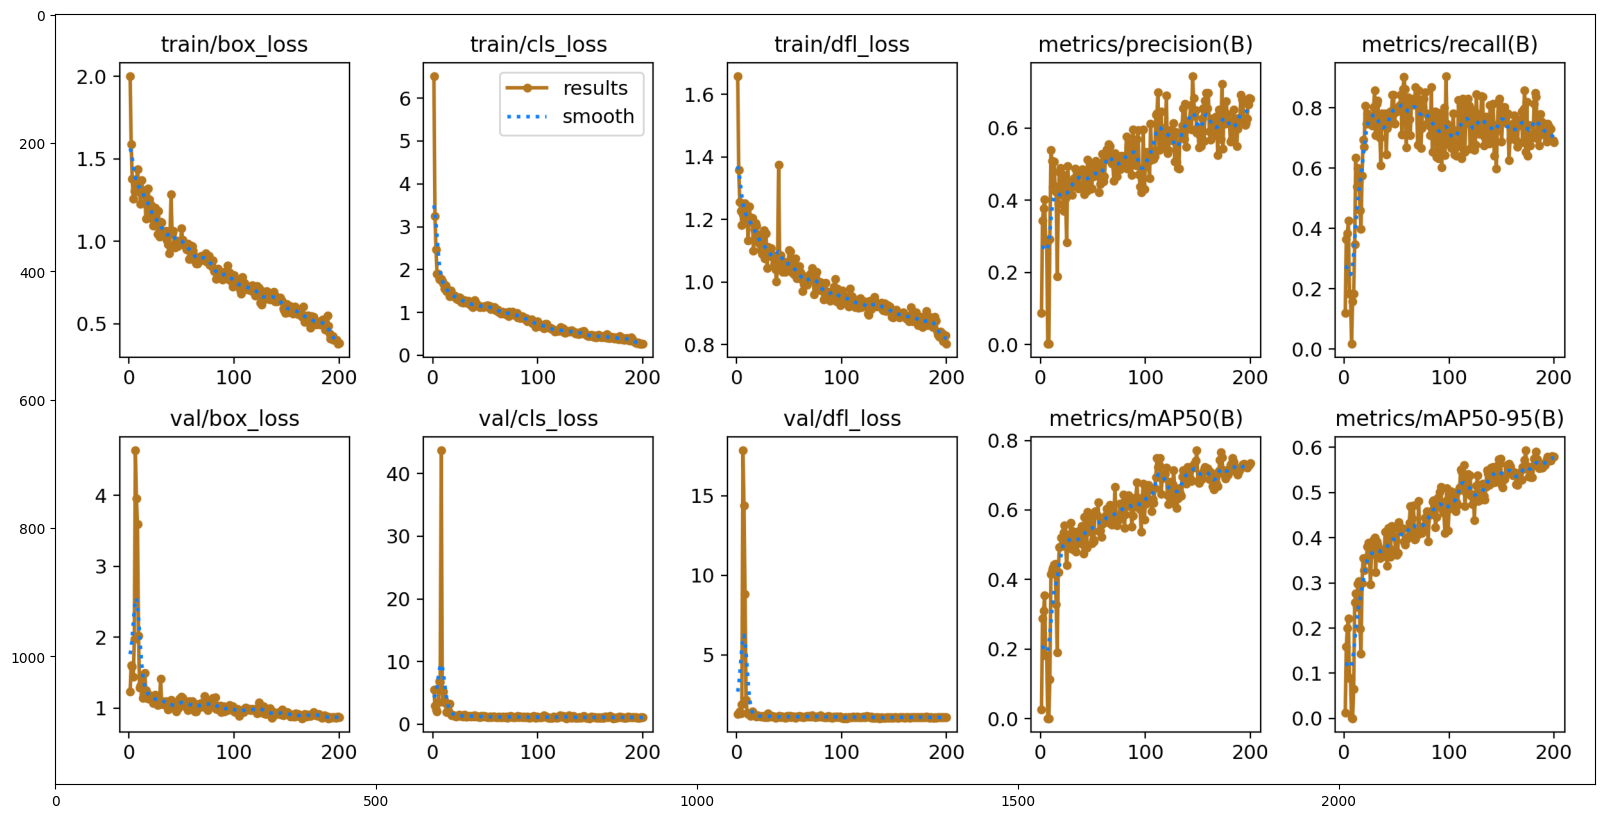

In [ ]:
sagittal_training_save_dir = '/content/' + str(sagittal_results.save_dir)

plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(sagittal_training_save_dir, 'results.png'))
plt.imshow(img)
plt.show()

**Menampilkan Confusion Matrix hasil training**

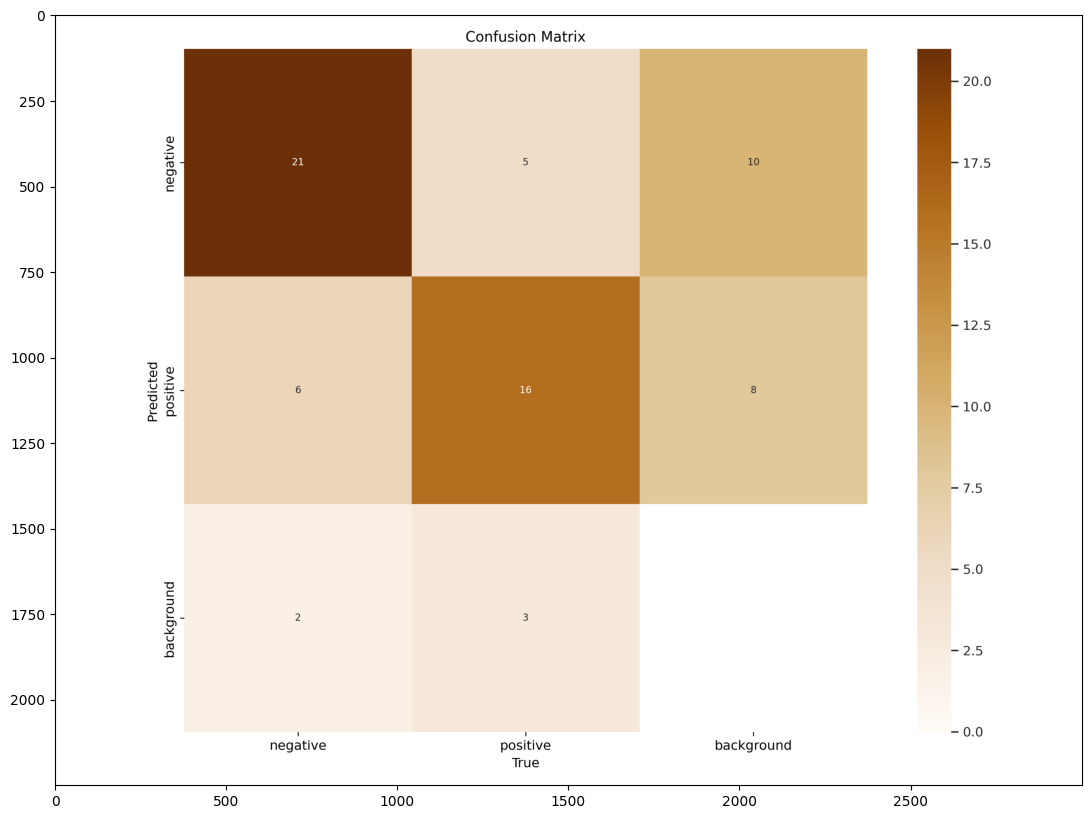

In [ ]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(sagittal_training_save_dir, 'confusion_matrix.png'))
plt.imshow(img)
plt.show()

**Menampilkan hasil training**

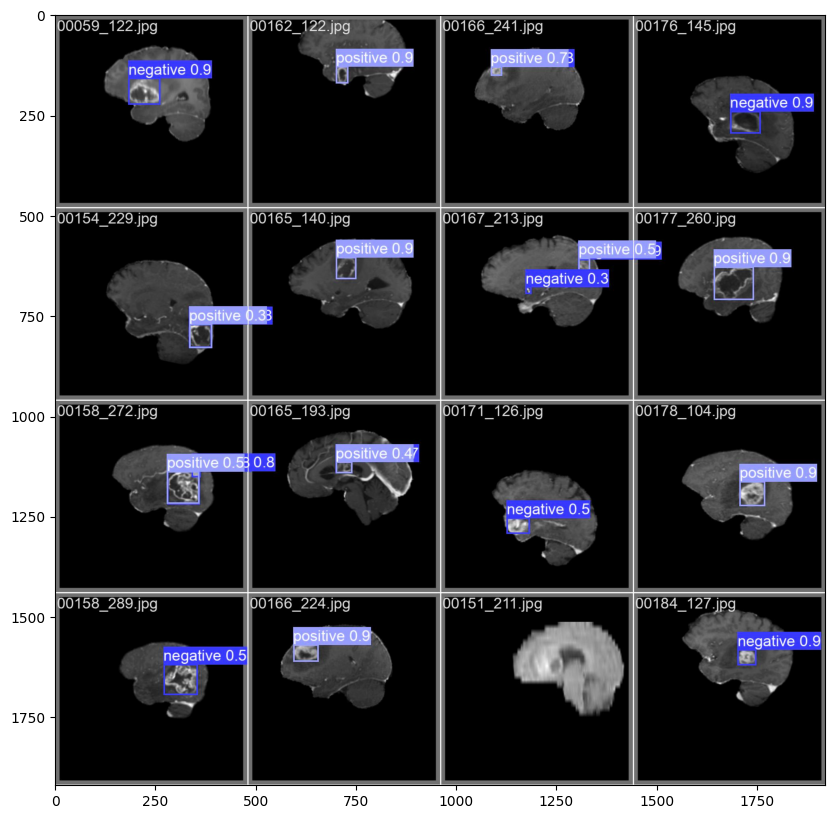

In [ ]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(sagittal_training_save_dir, 'val_batch0_pred.jpg'))
plt.imshow(img)
plt.show()

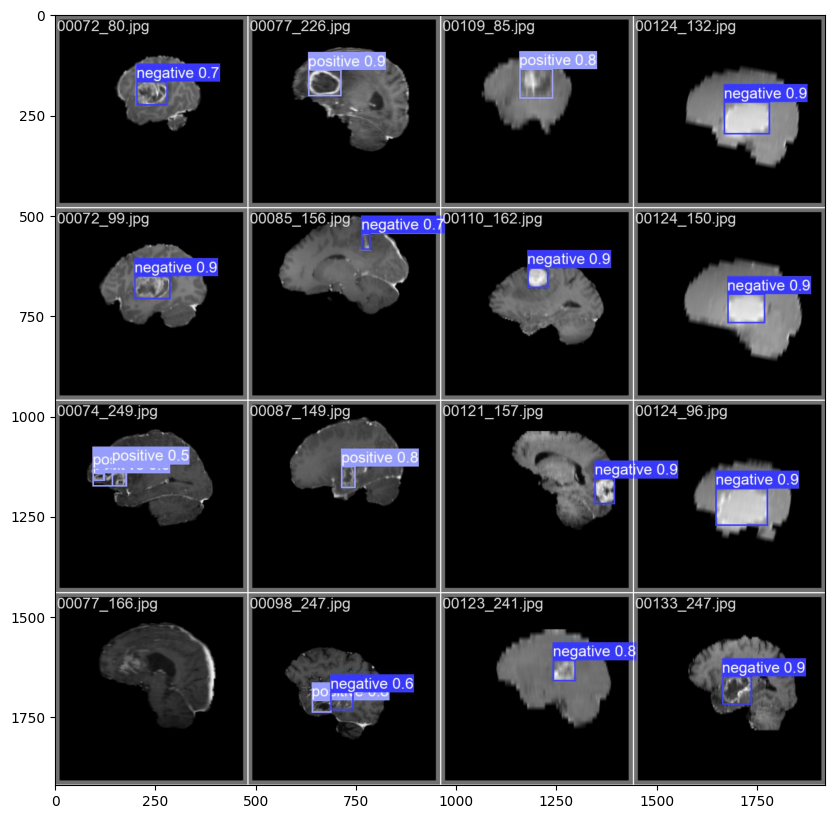

In [ ]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(sagittal_training_save_dir, 'val_batch1_pred.jpg'))
plt.imshow(img)
plt.show()

### Prediction / Testing

**Mengimplementasikan hasil training model ke test folder**

In [ ]:
sagittal_trained_model = YOLO(sagittal_training_save_dir + '/weights/best.pt')
sagittal_predictions = sagittal_trained_model.predict(
    source="/content/brain-tumor-object-detection-datasets/sagittal_t1wce_2_class/images/test",
    conf=0.4, save_txt=True, save_conf=True)


image 1/70 /content/brain-tumor-object-detection-datasets/sagittal_t1wce_2_class/images/test/00000_102.jpg: 640x640 1 positive, 16.0ms
image 2/70 /content/brain-tumor-object-detection-datasets/sagittal_t1wce_2_class/images/test/00000_121.jpg: 640x640 1 positive, 16.0ms
image 3/70 /content/brain-tumor-object-detection-datasets/sagittal_t1wce_2_class/images/test/00000_140.jpg: 640x640 1 negative, 16.0ms
image 4/70 /content/brain-tumor-object-detection-datasets/sagittal_t1wce_2_class/images/test/00000_159.jpg: 640x640 1 negative, 2 positives, 16.0ms
image 5/70 /content/brain-tumor-object-detection-datasets/sagittal_t1wce_2_class/images/test/00002_110.jpg: 640x640 1 positive, 16.0ms
image 6/70 /content/brain-tumor-object-detection-datasets/sagittal_t1wce_2_class/images/test/00002_129.jpg: 640x640 1 positive, 16.0ms
image 7/70 /content/brain-tumor-object-detection-datasets/sagittal_t1wce_2_class/images/test/00002_147.jpg: 640x640 1 positive, 16.0ms
image 8/70 /content/brain-tumor-object-de

In [ ]:
sagittal_predictions_save_dir = '/content/' + sagittal_predictions[0].save_dir + '/labels'

In [ ]:
text = """
path: /content/sagittal_dataset
train: images/train
val: images/test

# Classes
nc: 2
names: ['negative','positive']
"""
with open("./sagittal_test.yaml", 'w') as file:
    file.write(text)

In [ ]:
sagittal_metrics = sagittal_trained_model.val(data="sagittal_test.yaml")  # no arguments needed, dataset and settings remembered

Ultralytics YOLOv8.0.231 🚀 Python-3.10.12 torch-2.1.0+cu121 CUDA:0 (Tesla T4, 15102MiB)


val: Scanning /content/sagittal_dataset/labels/test... 70 images, 0 backgrounds, 0 corrupt: 100%|██████████| 70/70 [00:00<00:00, 673.05it/s]

val: New cache created: /content/sagittal_dataset/labels/test.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:05<00:00,  1.14s/it]


                   all         70         77      0.306      0.884      0.435      0.306
              negative         70         39      0.352      0.795      0.389      0.244
              positive         70         38      0.259      0.974      0.482      0.368
Speed: 0.9ms preprocess, 30.4ms inference, 0.0ms loss, 5.7ms postprocess per image
Results saved to runs/detect/val3


**Menampilkan Confusion Matrix hasil testing**

In [ ]:
sagittal_test_save_dir = '/content/' + str(sagittal_metrics.save_dir)

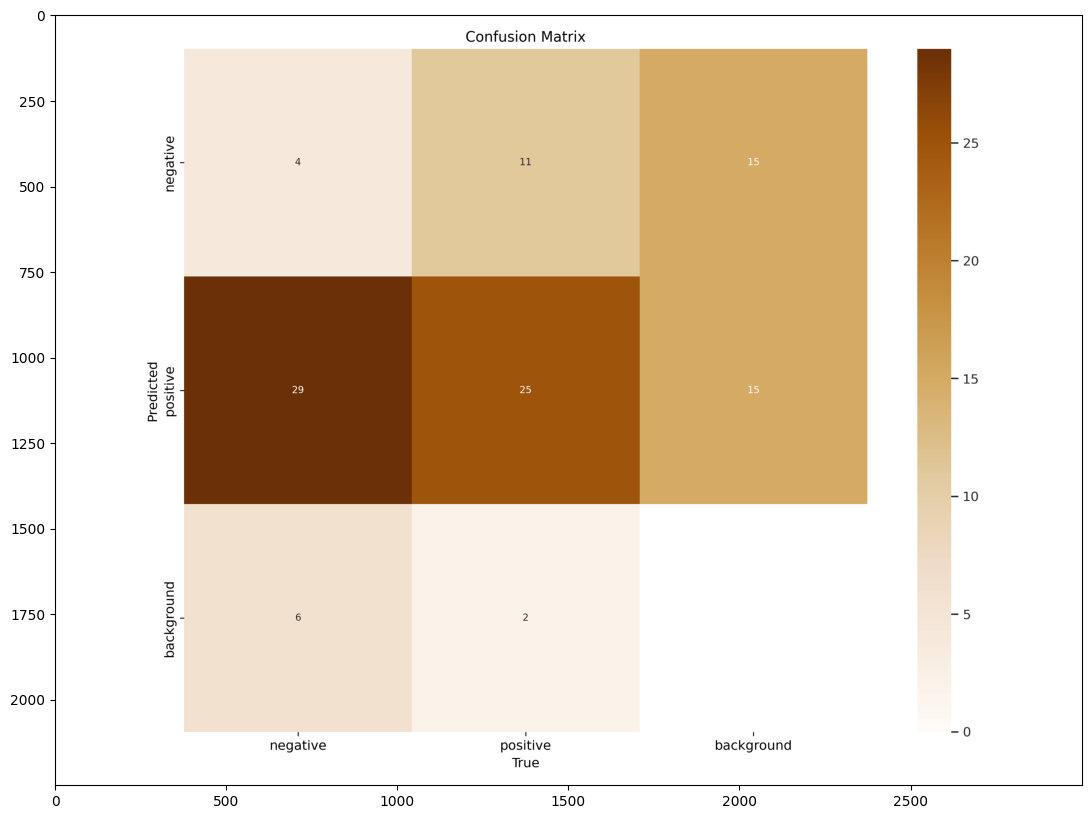

In [ ]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(sagittal_test_save_dir, 'confusion_matrix.png'))
plt.imshow(img)
plt.show()

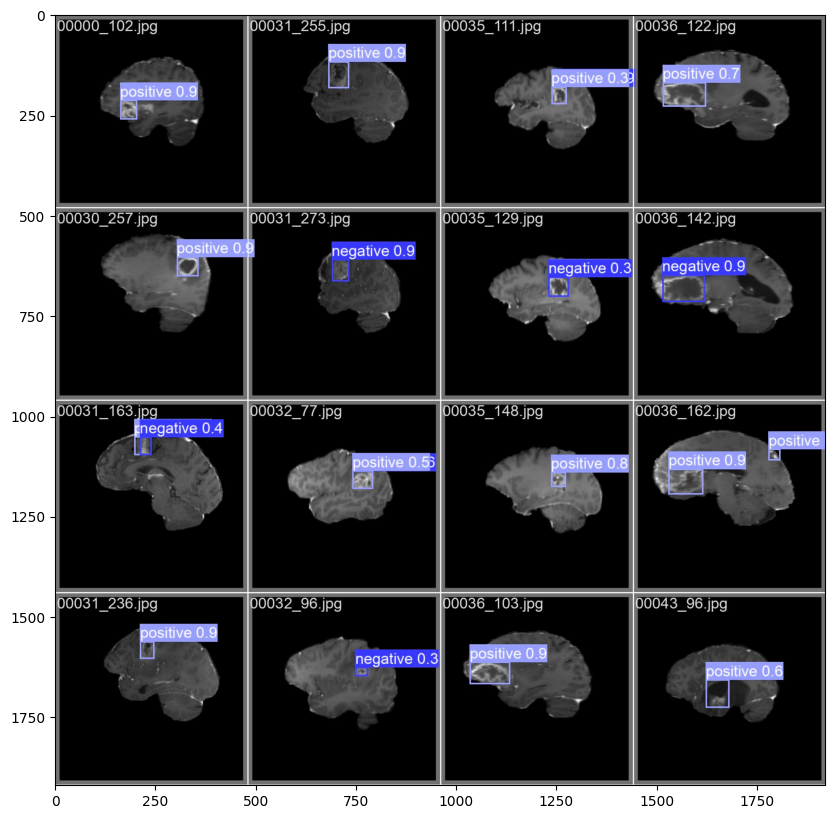

In [ ]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(sagittal_test_save_dir, 'val_batch0_pred.jpg'))
plt.imshow(img)
plt.show()

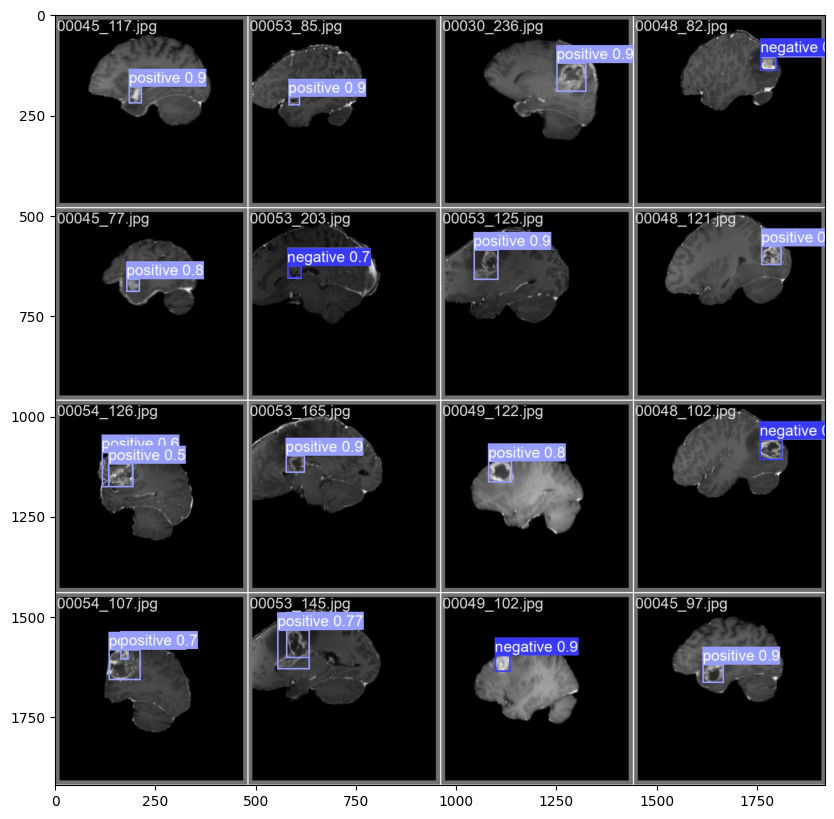

In [ ]:
plt.figure(figsize=(20, 10))
img = cv2.imread(os.path.join(sagittal_test_save_dir, 'val_batch1_pred.jpg'))
plt.imshow(img)
plt.show()

### Compare (repeatable)

['1', '0.619394', '0.406747', '0.110201', '0.111282', '0.795243\n']
['1', '0.619131', '0.409038', '0.109155', '0.111502']


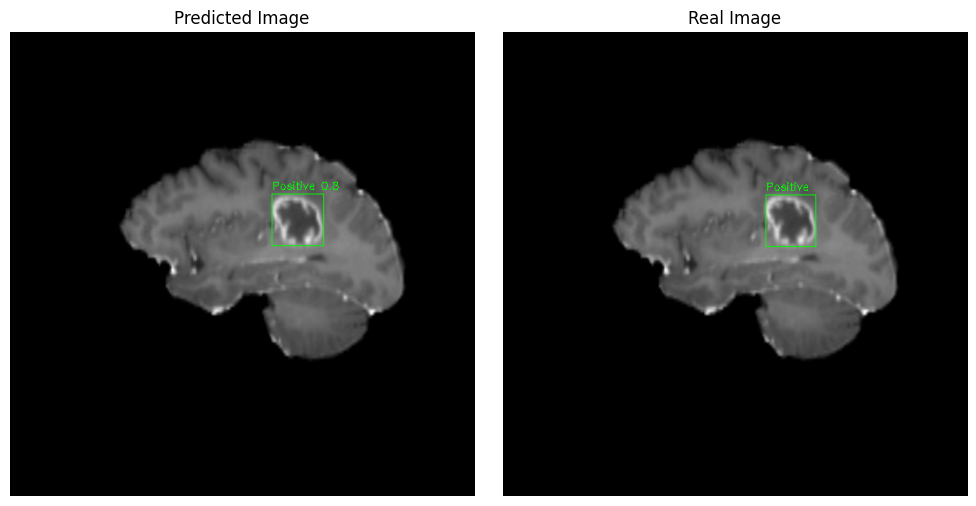

In [ ]:
def draw_bbox(file_path, filename, img):
    with open(os.path.join(file_path, f'{filename}.txt'),'r') as f:
        labels = f.readlines()
        labels = labels[0].split(' ')
        print(labels)
        f.close()

    tumor_class, x, y, w, h = int(labels[0]), float(labels[1]), float(labels[2]), float(labels[3]), float(labels[4])
    x_pt1 = int((x - w/2) * img.shape[1])
    y_pt1 = int((y - h/2) * img.shape[0])
    x_pt2 = int((x + w/2) * img.shape[1])
    y_pt2 = int((y + h/2) * img.shape[0])

    if tumor_class == 0:
        colour = (255, 0, 0)
        label = 'Negative'
    else:
        colour = (0, 255, 0)
        label = 'Positive'
    if len(labels) > 5:
        prob = float(labels[5])
        prob = round(prob, 1)
        prob = str(prob)
        label = label + ' ' + prob

    cv2.rectangle(img, (x_pt1, y_pt1), (x_pt2, y_pt2), colour, 1)
    cv2.putText(img, label, (x_pt1, y_pt1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, colour, 1)

files = os.listdir(sagittal_predictions_save_dir)
random_file = random.choice(files)
random_file = os.path.splitext(random_file)[0]

img_pred = cv2.imread(os.path.join('sagittal_dataset/images/test', f'{random_file}.jpg'), 1)
img_pred = cv2.cvtColor(img_pred, cv2.COLOR_BGR2RGB)
draw_bbox(sagittal_predictions_save_dir, random_file, img_pred)

img_real = cv2.imread(os.path.join('sagittal_dataset/images/test', f'{random_file}.jpg'), 1)
img_real = cv2.cvtColor(img_real, cv2.COLOR_BGR2RGB)
draw_bbox('sagittal_dataset/labels/test', random_file, img_real)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img_pred)
axes[0].set_title('Predicted Image')
axes[0].axis('off')

axes[1].imshow(img_real)
axes[1].set_title('Real Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()